In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from datetime import datetime
from pytz import timezone

now = datetime.strftime(datetime.now(timezone('Asia/Seoul')), "%Y%m%d%H%M%S")
print(now)
print(datetime.now(timezone('Asia/Seoul')))

20221020154243
2022-10-20 15:42:43.832078+09:00


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels as sm
import sklearn
from datetime import datetime



Matplotlib created a temporary config/cache directory at /tmp/matplotlib-m9iats55 because the default path (/home/hyunjung_p/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [4]:
os.getcwd()

'/workspace/nas100_vol2/projects/04_PFT/src/DATA_sampling_check'

In [5]:
# temporally independent test set (Jan 2018 to Dec 2018)

df_2018 = pd.read_excel("/workspace/nas100_vol2/projects/04_PFT/data/00_DATA_info/external_validation/PFT_LDCT_weak_external_with_testresult(21Jul_first_result).xlsx",
                        index_col = 0
                       )
print(df_2018.shape)



(2720, 90)


In [6]:
df_2018.rename(columns = {"건진일자":"exam_date",
                         "나이":"age", 
                         "성별":"sex", 
                         "체중":"Wt",
                         "키":"Ht",
                         "허리둘레":"AC"}, inplace = True)

In [173]:
# development set (Jan 2015 to Dec 2017)
df_devel = pd.read_excel("/workspace/nas100_vol2/projects/04_PFT/data/00_DATA_info/PFT_LDCT_info(0806)/PFT_LDCT_fv_filtered_with_path(210429).xlsx", 
                        index_col = 0)


    
df_devel.rename(columns = {"FVC_PRED_percent":"FVC_%PRED"}, inplace = True)
# print(df_devel.shape)
# for _i, _key in enumerate(df_devel.keys()):
#     print(_i, _key)

# Figure 1 check (Reviwer 1 - 5th comment)

In [10]:
print(df_devel["set_split"].value_counts())
print("\n")
print("proprotion in development set")
print(df_devel["set_split"].value_counts() / df_devel.shape[0] * 100)

train    9398
test     2687
valid    1343
Name: set_split, dtype: int64


train    69.988085
test     20.010426
valid    10.001489
Name: set_split, dtype: float64


In [11]:
df_test_internal = df_devel[df_devel["set_split"] =="test"]

In [14]:
print("number of participants FVC% <80",df_test_internal[df_test_internal["FVC_%PRED"] <80].shape)
print("proportion in internal test set",df_test_internal[df_test_internal["FVC_%PRED"] <80].shape[0] / df_test_internal.shape[0] * 100)

(330, 66)
12.281354670636398


In [13]:
print("number of participants FEV1% <70",df_test_internal[df_test_internal["FEV1_%PRED"] <80].shape)
print("proportion in internal test set",df_test_internal[df_test_internal["FEV1_%PRED"] <80].shape[0] / df_test_internal.shape[0] * 100)

(405, 66)
15.07257164123558


In [12]:
print("number of participants FEV1/FVC <70",df_test_internal[df_test_internal["FEV1/FVC_MEAS"] <70].shape)
print("proportion in internal test set", df_test_internal[df_test_internal["FEV1/FVC_MEAS"] <70].shape[0] / df_test_internal.shape[0] * 100)

(255, 66)
9.490137700037216


# development set : Table S1
## compare training set with validation and test set

## 1) ratio of PFT severity

In [18]:
list_set = ["train", "valid", "test"]
list_col = ["FEV1/FVC_MEAS", "FVC_%PRED", "FEV1_%PRED"]
list_cutoff = [70, 80, 80]
dict_dist = dict()
for _set in list_set:
    df_target = df_devel[df_devel["set_split"] == _set]
    dict_dist[_set] =dict() 
    for _col, _cutoff in zip(list_col, list_cutoff):
        n_target = df_target[df_target[_col] <_cutoff].shape[0]
        ratio_target = np.round(df_target[df_target[_col] <_cutoff].shape[0] / df_target.shape[0] * 100, 2)
        
        value_target = f"{n_target}/{df_target.shape[0]} ({ratio_target} %)"
        
        dict_dist[_set][_col] = value_target

        
df_target = df_devel.copy()
dict_dist["devel_overall"] =dict() 
for _col, _cutoff in zip(list_col, list_cutoff):
    n_target = df_target[df_target[_col] <_cutoff].shape[0]
    ratio_target = np.round(df_target[df_target[_col] <_cutoff].shape[0] / df_target.shape[0] * 100, 2)

    value_target = f"{n_target}/{df_target.shape[0]} ({ratio_target} %)"

    dict_dist["devel_overall"][_col] = value_target

        
df_dist = pd.DataFrame.from_dict(dict_dist, orient = "columns")
display(df_dist)
    

,train,valid,test,devel_overall
FEV1/FVC_MEAS,919/9398 (9.78 %),132/1343 (9.83 %),255/2687 (9.49 %),1306/13428 (9.73 %)
FVC_%PRED,1244/9398 (13.24 %),143/1343 (10.65 %),330/2687 (12.28 %),1717/13428 (12.79 %)
FEV1_%PRED,1452/9398 (15.45 %),197/1343 (14.67 %),405/2687 (15.07 %),2054/13428 (15.3 %)


In [16]:
    
from scipy.stats import chi2_contingency

list_set = ["train", "valid", "test"]
list_col = ["FEV1/FVC_MEAS", "FVC_%PRED", "FEV1_%PRED"]
list_cutoff = [70, 80, 80]
dict_dist = dict()

for _col, _cutoff in zip(list_col, list_cutoff):
        
    for _set in list_set:
        df_target = df_devel[df_devel["set_split"] == _set]
        dict_dist[_set] =dict() 
        
        n_target_positive = df_target[df_target[_col] <_cutoff].shape[0]
        n_target_negative =  df_target.shape[0] - df_target[df_target[_col] <_cutoff].shape[0]
        
        dict_dist[_set]["under cutoff"] = n_target_positive
        dict_dist[_set]["equal/over cutoff"] = n_target_negative

    df_dist = pd.DataFrame.from_dict(dict_dist, orient = "columns")
    display(df_dist)


    chi2, p, dof, ex = chi2_contingency(df_dist,
                                   correction = False)
    
    print(_col)
    print("chi2: ", chi2)
    print("pvalue: ", p)
    
    
    
    
    

,train,valid,test
under cutoff,919,132,255
equal/over cutoff,8479,1211,2432


FEV1/FVC_MEAS
chi2:  0.21609841959596343
pvalue:  0.8975834254445832


,train,valid,test
under cutoff,1244,143,330
equal/over cutoff,8154,1200,2357


FVC_%PRED
chi2:  7.832599644264483
pvalue:  0.01991464631704806


,train,valid,test
under cutoff,1452,197,405
equal/over cutoff,7946,1146,2282


FEV1_%PRED
chi2:  0.6837071075103528
pvalue:  0.7104522401538882


In [ ]:
# https://danilzherebtsov.medium.com/continuous-data-stratification-c121fc91964b

## 2) continuous variables distribution

In [19]:
df_devel.keys()

Index(['examID', 'ID_path', 'dir_name', 'target_path', 'check_dir_exist',
       '연구번호', 'HE0108(R5253A)검사접수번호', 'HE0109(R5253)검사접수번호', 'EXCEL',
       'PYTHON', 'sex', 'exam_date', 'age', '내원번호', 'Ht', 'Wt', 'BMI', 'AC',
       'SBP', 'DBP', 'Q0002 귀하께서는 암을 진단 받은 적이 있습니까?',
       'Q0003 진단 받은 암을 선택해 주시겠습니까? (복수 응답 가능)',
       'Q0214 폐질환, 신장/요로/전립선질환, 간/담도질환, 식도/위/대장질환 및 갑상선 질환이 있습니까?',
       'Q0229 과거력(폐,비뇨기,소화기,갑상선) 을 선택해 주시겠습니까? (복수 응답 가능)',
       'Q0012 복용/주사 중인 약을 선택해 주시겠습니까? (복수 응답 가능)',
       'Q0016 시술 혹은 수술을 선택해주시겠습니까?(복수 응답 가능)', 'Q0047 귀하는 담배를 피운적이 있습니까?',
       'Q0048 처음 흡연을 시작한 연령은 몇 세입니까?', 'Q0049 흡연을 중단한 연령은 몇 세입니까?',
       'Q0050 하루 평균 흡연량은 얼마입니까? (현재 끊으신분도 과거 하루 평균 흡연량 표시바랍니다)',
       'Q0089 숨찬 증상이 있습니까?', 'Q0211 흉부 통증이 있습니까?',
       'Q0090 상기도 및 호흡기계 증상이 있습니까?', 'R5253A 접수일자', 'R5253A 결과본문', 'R5253A 결론',
       'R5253 접수일자', 'R5253 결과본문', 'R5253 결론', 'S2001 접수일자', 'S2001 결론',
       'S2002 접수일자', 'S2002 결론', 'FVC_PRED', 'FVC_MEAS', 'FVC_%PRED',
       'FEV1_PR

In [139]:
list_set = ["train", "valid", "test"]
list_col = ["age", "BMI",  "FVC_MEAS","FVC_%PRED","FEV1_MEAS", "FEV1_%PRED", "FEV1/FVC_MEAS" ]
# list_cutoff = [70, 80, 80]


for _order, _round_decimal in enumerate([2,1]):
    dict_dist = dict()

    for _set in list_set:
        
        df_target = df_devel[df_devel["set_split"] == _set]
        dict_dist[_set] =dict() 
        if _order ==0:
            print(_set)
            display(df_target[list_col].describe())

        for _col in list_col:



            mean_col  = df_target[_col].mean().round(_round_decimal)
            std_col =  df_target[_col].std().round(_round_decimal)

            value_col = f"{mean_col}$\pm${std_col}"
            dict_dist[_set][_col] = value_col

    #==============
    df_target = df_devel.copy()
    if _order ==0:
        print("devel_overall")
        display(df_target[list_col].describe())
    dict_dist["devel_overall"] =dict() 
    for _set in list_set:


        for _col in list_col:



            mean_col  = df_target[_col].mean().round(_round_decimal)
            std_col =  df_target[_col].std().round(_round_decimal)

            value_col = f"{mean_col}$\pm${std_col}"
            dict_dist["devel_overall"][_col] = value_col


    #==============


    df_dist = pd.DataFrame.from_dict(dict_dist, orient = "columns")
    display(df_dist)




train


,age,BMI,FVC_MEAS,FVC_%PRED,FEV1_MEAS,FEV1_%PRED,FEV1/FVC_MEAS
count,9398.000000,9398.00000,9398.000000,9398.000000,9398.000000,9398.000000,9398.000000
mean,54.698553,23.92386,3.914488,90.994254,3.036314,90.431156,77.761864
std,9.818666,3.09804,0.831036,10.917248,0.665807,11.735172,6.763059
min,18.000000,0.00000,1.420000,37.000000,1.040000,37.000000,39.000000
25%,50.000000,21.91700,3.280000,84.000000,2.550000,83.000000,74.000000
50%,55.000000,23.79450,3.930000,91.000000,3.020000,91.000000,78.000000
75%,60.000000,25.73700,4.510000,98.000000,3.490000,98.000000,82.000000
max,90.000000,40.89500,7.160000,135.000000,5.660000,140.000000,100.000000


valid


,age,BMI,FVC_MEAS,FVC_%PRED,FEV1_MEAS,FEV1_%PRED,FEV1/FVC_MEAS
count,1343.000000,1343.000000,1343.000000,1343.000000,1343.000000,1343.000000,1343.000000
mean,53.680566,23.780522,3.942576,91.236783,3.061296,90.192852,77.812360
std,9.777935,3.080101,0.844235,10.374604,0.681870,11.042158,6.817217
min,21.000000,0.000000,1.550000,56.000000,1.170000,46.000000,46.000000
25%,48.000000,21.737000,3.285000,84.000000,2.560000,83.500000,74.000000
50%,54.000000,23.701000,3.970000,91.000000,3.040000,90.000000,78.000000
75%,59.000000,25.458500,4.545000,98.000000,3.530000,98.000000,82.000000
max,85.000000,45.268000,7.320000,126.000000,5.620000,125.000000,97.000000


test


,age,BMI,FVC_MEAS,FVC_%PRED,FEV1_MEAS,FEV1_%PRED,FEV1/FVC_MEAS
count,2687.000000,2687.000000,2687.000000,2687.000000,2687.000000,2687.000000,2687.000000
mean,54.797172,23.907681,3.912869,90.910681,3.039326,90.471157,77.838854
std,9.461456,3.175390,0.808033,10.759030,0.654980,11.792534,6.773850
min,20.000000,0.000000,1.720000,45.000000,1.120000,42.000000,41.000000
25%,50.000000,21.893000,3.290000,84.000000,2.555000,83.000000,74.000000
50%,55.000000,23.828000,3.930000,90.000000,3.020000,90.000000,78.000000
75%,61.000000,25.701000,4.485000,98.000000,3.480000,98.000000,82.000000
max,86.000000,44.427000,6.890000,129.000000,5.220000,146.000000,99.000000


devel_overall


,age,BMI,FVC_MEAS,FVC_%PRED,FEV1_MEAS,FEV1_%PRED,FEV1/FVC_MEAS
count,13428.000000,13428.000000,13428.000000,13428.000000,13428.000000,13428.000000,13428.000000
mean,54.616473,23.906286,3.916973,91.001787,3.039415,90.415326,77.782321
std,9.748498,3.111947,0.827803,10.832124,0.665275,11.678690,6.770222
min,18.000000,0.000000,1.420000,37.000000,1.040000,37.000000,39.000000
25%,49.000000,21.899000,3.280000,84.000000,2.550000,83.000000,74.000000
50%,55.000000,23.795000,3.930000,91.000000,3.025000,90.000000,78.000000
75%,60.000000,25.709000,4.510000,98.000000,3.490000,98.000000,82.000000
max,90.000000,45.268000,7.320000,135.000000,5.660000,146.000000,100.000000


,train,valid,test,devel_overall
age,54.7$\pm$9.82,53.68$\pm$9.78,54.8$\pm$9.46,54.62$\pm$9.75
BMI,23.92$\pm$3.1,23.78$\pm$3.08,23.91$\pm$3.18,23.91$\pm$3.11
FVC_MEAS,3.91$\pm$0.83,3.94$\pm$0.84,3.91$\pm$0.81,3.92$\pm$0.83
FVC_%PRED,90.99$\pm$10.92,91.24$\pm$10.37,90.91$\pm$10.76,91.0$\pm$10.83
FEV1_MEAS,3.04$\pm$0.67,3.06$\pm$0.68,3.04$\pm$0.65,3.04$\pm$0.67
FEV1_%PRED,90.43$\pm$11.74,90.19$\pm$11.04,90.47$\pm$11.79,90.42$\pm$11.68
FEV1/FVC_MEAS,77.76$\pm$6.76,77.81$\pm$6.82,77.84$\pm$6.77,77.78$\pm$6.77


,train,valid,test,devel_overall
age,54.7$\pm$9.8,53.7$\pm$9.8,54.8$\pm$9.5,54.6$\pm$9.7
BMI,23.9$\pm$3.1,23.8$\pm$3.1,23.9$\pm$3.2,23.9$\pm$3.1
FVC_MEAS,3.9$\pm$0.8,3.9$\pm$0.8,3.9$\pm$0.8,3.9$\pm$0.8
FVC_%PRED,91.0$\pm$10.9,91.2$\pm$10.4,90.9$\pm$10.8,91.0$\pm$10.8
FEV1_MEAS,3.0$\pm$0.7,3.1$\pm$0.7,3.0$\pm$0.7,3.0$\pm$0.7
FEV1_%PRED,90.4$\pm$11.7,90.2$\pm$11.0,90.5$\pm$11.8,90.4$\pm$11.7
FEV1/FVC_MEAS,77.8$\pm$6.8,77.8$\pm$6.8,77.8$\pm$6.8,77.8$\pm$6.8


------------------------------------------------------------
age
------------------------------------------------------------


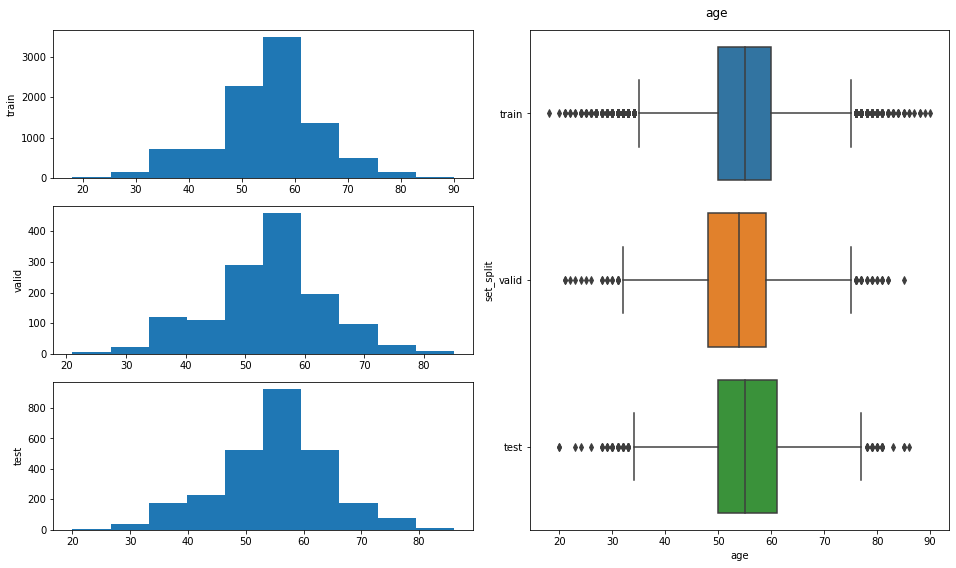

------------------------------------------------------------
BMI
------------------------------------------------------------


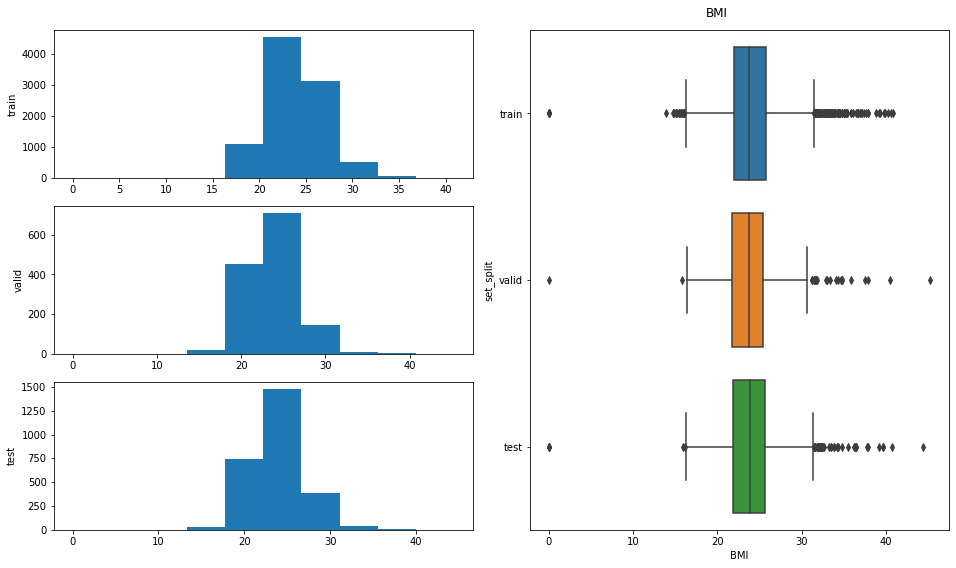

------------------------------------------------------------
FVC_MEAS
------------------------------------------------------------


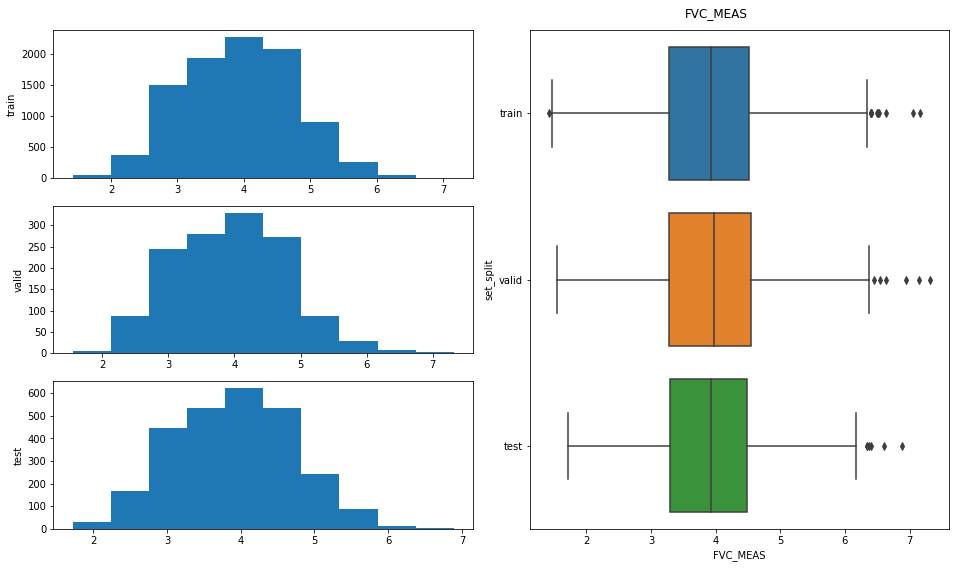

------------------------------------------------------------
FVC_%PRED
------------------------------------------------------------


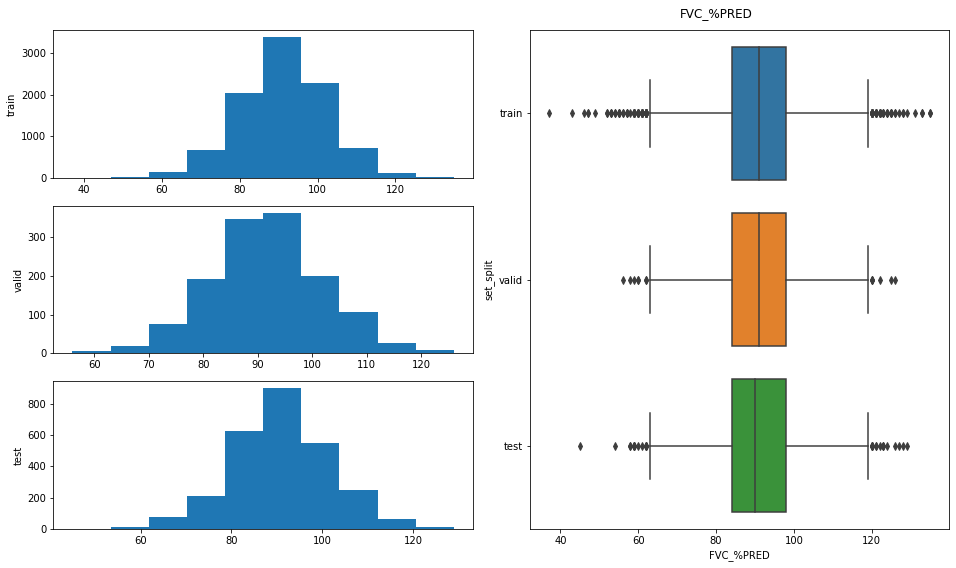

------------------------------------------------------------
FEV1_MEAS
------------------------------------------------------------


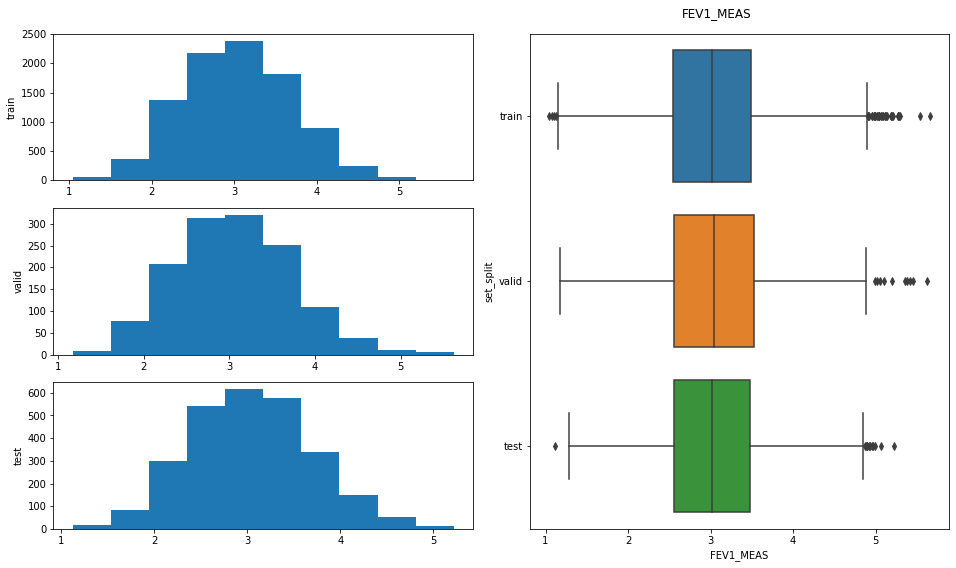

------------------------------------------------------------
FEV1_%PRED
------------------------------------------------------------


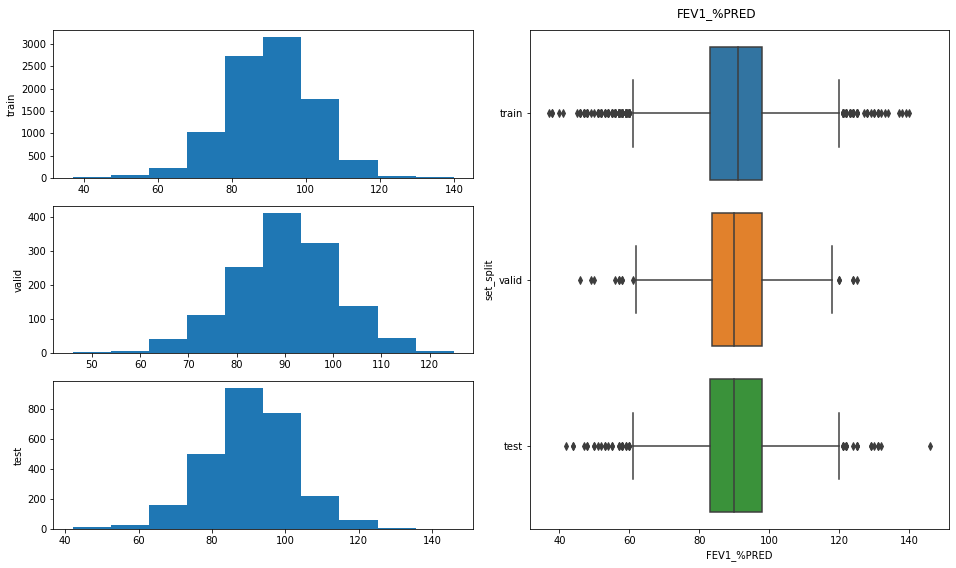

------------------------------------------------------------
FEV1/FVC_MEAS
------------------------------------------------------------


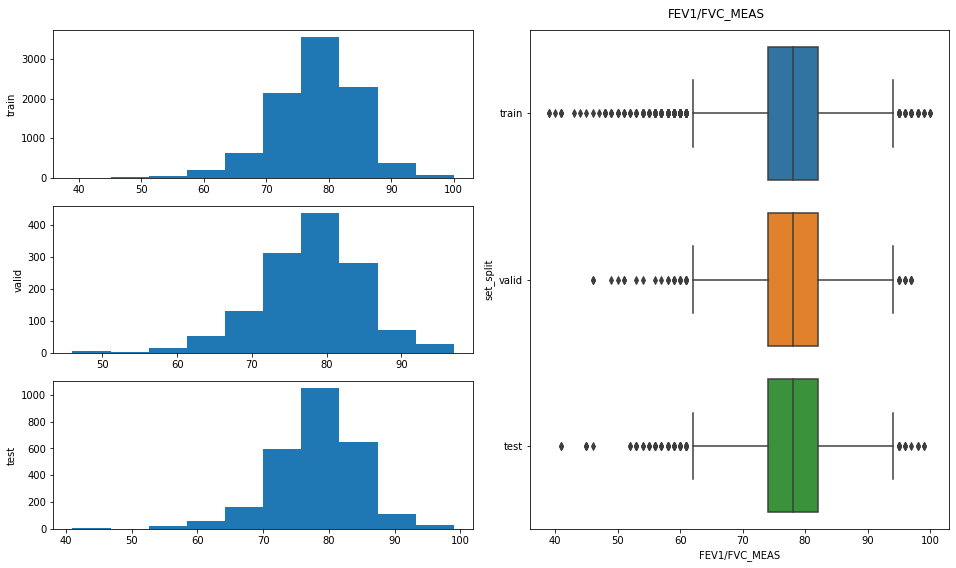

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
import seaborn as sns

list_set = ["train", "valid", "test"]
list_col = ["age", "BMI",  "FVC_MEAS","FVC_%PRED","FEV1_MEAS", "FEV1_%PRED", "FEV1/FVC_MEAS" ]
for col in list_col:
    print("--"*30)
    print(col)
    print("--"*30)
#     f, a = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 5))
#     vmin = df_devel[col].min()
#     vmax = df_devel[col].max()
#     for i, _set in enumerate(list_set):
#         df_target = df_devel[df_devel["set_split"] == _set]
#         a[i].hist(df_target[col])
#         a[i].set_xlim(vmin, vmax)
#     plt.tight_layout()
#     plt.show()
    
    #--
    fig = plt.figure(tight_layout=True,
                    figsize = (20,8))
    fig.suptitle(col)
    gs = gridspec.GridSpec(3, 3)
    for i, _set in enumerate(list_set):
        df_target = df_devel[df_devel["set_split"] == _set]
        ax = fig.add_subplot(gs[i, 0])
        ax.hist(df_target[col])
        ax.set_ylabel(_set)
        
        
    ax = fig.add_subplot(gs[:, 1])
    sns.boxplot(data=df_devel, x=col, y="set_split",
                order = ["train", "valid", "test" ],
                ax = ax)
    fig.subplots_adjust(top=0.5)
#     df_devel.boxplot(column=[cdf_develol], by=["df_devel"], ax = ax)
    plt.tight_layout()
    plt.show()

In [142]:
from scipy.stats import mannwhitneyu

In [163]:
list_compareset = ["valid", "test"]
list_col = ["age", "BMI", "FVC_MEAS",  "FVC_%PRED",  "FEV1_MEAS","FEV1_%PRED","FEV1/FVC_MEAS"]


df_train = df_devel[df_devel["set_split"] =="train"]
display(df_train[list_col].describe().T)
for _compareset in list_compareset:
    df_compare = df_devel[df_devel["set_split"] ==_compareset]
    

    result =ttest_ind(df_train[list_col], df_compare[list_col],
             equal_var = False
             )      
    print("==============")
    print("train vs", _compareset, "t test for independet 2 samples")
    print(df_train.shape, df_compare.shape)
    display(df_compare[list_col].describe().T)
    display(pd.DataFrame(zip(result.statistic, result.pvalue), 
         index = list_col, 
         columns = ["statistic", "pvalue"]))
    
    
    print("\n\n\n\==============")
    list_statistic = []
    list_pvalue = []
    for _col in list_col:
        result =mannwhitneyu(df_train[_col], df_compare[_col]
    #              equal_var = False
                 ) 
        list_statistic.append(result.statistic)
        list_pvalue.append(result.pvalue)
    print("train vs", _compareset, "mann whitney u test")

    display(pd.DataFrame(zip(list_statistic, list_pvalue), 
         index = list_col, 
         columns = ["statistic", "pvalue"]))
    
    
    print("\n\n\n\==============")

    

,count,mean,std,min,25%,50%,75%,max
age,9398.0,54.698553,9.818666,18.00,50.000,55.0000,60.000,90.000
BMI,9398.0,23.923860,3.098040,0.00,21.917,23.7945,25.737,40.895
FVC_MEAS,9398.0,3.914488,0.831036,1.42,3.280,3.9300,4.510,7.160
FVC_%PRED,9398.0,90.994254,10.917248,37.00,84.000,91.0000,98.000,135.000
FEV1_MEAS,9398.0,3.036314,0.665807,1.04,2.550,3.0200,3.490,5.660
FEV1_%PRED,9398.0,90.431156,11.735172,37.00,83.000,91.0000,98.000,140.000
FEV1/FVC_MEAS,9398.0,77.761864,6.763059,39.00,74.000,78.0000,82.000,100.000


train vs valid t test for independet 2 samples
(9398, 66) (1343, 66)


,count,mean,std,min,25%,50%,75%,max
age,1343.0,53.680566,9.777935,21.00,48.000,54.000,59.0000,85.000
BMI,1343.0,23.780522,3.080101,0.00,21.737,23.701,25.4585,45.268
FVC_MEAS,1343.0,3.942576,0.844235,1.55,3.285,3.970,4.5450,7.320
FVC_%PRED,1343.0,91.236783,10.374604,56.00,84.000,91.000,98.0000,126.000
FEV1_MEAS,1343.0,3.061296,0.681870,1.17,2.560,3.040,3.5300,5.620
FEV1_%PRED,1343.0,90.192852,11.042158,46.00,83.500,90.000,98.0000,125.000
FEV1/FVC_MEAS,1343.0,77.812360,6.817217,46.00,74.000,78.000,82.0000,97.000


,statistic,pvalue
age,3.566990,0.000371
BMI,1.594086,0.111097
FVC_MEAS,-1.142712,0.253316
FVC_%PRED,-0.796032,0.426119
FEV1_MEAS,-1.259558,0.207999
FEV1_%PRED,0.733877,0.463119
FEV1/FVC_MEAS,-0.254164,0.799399





\==============
train vs valid mann whitney u test


,statistic,pvalue
age,5914318.5,0.000095
BMI,6125821.0,0.040942
FVC_MEAS,6223668.0,0.206301
FVC_%PRED,6266373.5,0.338074
FEV1_MEAS,6210272.5,0.172239
FEV1_%PRED,6248943.0,0.280366
FEV1/FVC_MEAS,6300568.5,0.461774





\==============
train vs test t test for independet 2 samples
(9398, 66) (2687, 66)


,count,mean,std,min,25%,50%,75%,max
age,2687.0,54.797172,9.461456,20.00,50.000,55.000,61.000,86.000
BMI,2687.0,23.907681,3.175390,0.00,21.893,23.828,25.701,44.427
FVC_MEAS,2687.0,3.912869,0.808033,1.72,3.290,3.930,4.485,6.890
FVC_%PRED,2687.0,90.910681,10.759030,45.00,84.000,90.000,98.000,129.000
FEV1_MEAS,2687.0,3.039326,0.654980,1.12,2.555,3.020,3.480,5.220
FEV1_%PRED,2687.0,90.471157,11.792534,42.00,83.000,90.000,98.000,146.000
FEV1/FVC_MEAS,2687.0,77.838854,6.773850,41.00,74.000,78.000,82.000,99.000


,statistic,pvalue
age,-0.472440,0.636636
BMI,0.234163,0.814870
FVC_MEAS,0.090997,0.927499
FVC_%PRED,0.353912,0.723422
FEV1_MEAS,-0.209455,0.834102
FEV1_%PRED,-0.155228,0.876649
FEV1/FVC_MEAS,-0.519730,0.603278





\==============
train vs test mann whitney u test


,statistic,pvalue
age,12606075.5,0.449727
BMI,12565319.0,0.351294
FVC_MEAS,12602590.5,0.441124
FVC_%PRED,12499877.5,0.214033
FEV1_MEAS,12597901.5,0.429548
FEV1_%PRED,12607080.0,0.452236
FEV1/FVC_MEAS,12569415.0,0.360701





\==============


## 3) ratio male/ female

In [ ]:
# chi2 of 2*3 matrix

In [66]:
from scipy.stats import chi2_contingency

list_set = ["train", "valid", "test"]

dict_dist = dict()

        
for _set in list_set:
    df_target = df_devel[df_devel["set_split"] == _set]
    dict_dist[_set] =dict() 

    n_target_male = df_target[df_target["sex"] =="M"].shape[0]
    n_target_female =  df_target[df_target["sex"] =="F"].shape[0]

    dict_dist[_set]["M"] = n_target_male
    dict_dist[_set]["F"] = n_target_female
    dict_dist[_set]["ratio_Male"]  =np.round(n_target_male / df_target.shape[0] * 100, 2) 

df_dist = pd.DataFrame.from_dict(dict_dist, orient = "columns")
display(df_dist)


chi2, p, dof, ex = chi2_contingency(df_dist.loc["M":"F"],
                               correction = False)

print(f"chi2 test of 2 by 3 with degree of freedom {dof}")
print("chi2", chi2)
print("p value", p)


,train,valid,test
M,6444.00,927.00,1867.00
F,2954.00,416.00,820.00
ratio_Male,68.57,69.02,69.48


chi2 test of 2 by 3 with degree of freedom 2
chi2 0.8509386172360069
p value 0.6534630373208208


In [61]:
df_dist.loc["M":"F"]

,train,valid,test
M,6444.0,927.0,1867.0
F,2954.0,416.0,820.0


In [67]:
# chi2 of 2*2 matrix

In [68]:
from scipy.stats import chi2_contingency

list_set = ["train", "valid", "test"]

dict_dist = dict()

        
for _set in list_set:
    df_target = df_devel[df_devel["set_split"] == _set]
    dict_dist[_set] =dict() 

    n_target_male = df_target[df_target["sex"] =="M"].shape[0]
    n_target_female =  df_target[df_target["sex"] =="F"].shape[0]

    dict_dist[_set]["M"] = n_target_male
    dict_dist[_set]["F"] = n_target_female
    dict_dist[_set]["ratio_Male"]  =np.round(n_target_male / df_target.shape[0] * 100, 1) 

df_dist = pd.DataFrame.from_dict(dict_dist, orient = "columns")
display(df_dist)
df_dist = df_dist.loc["M":"F"]

for _compareset in  "valid", "test":
    print("-"*40)
    df_contingency = pd.concat([df_dist["train"],\
                                df_dist[_compareset]], 
                              axis = 1)

    display(df_contingency)

    chi2, p, dof, ex = chi2_contingency(df_contingency,
                                       correction = False)
    print("gender", " comparing train vs", _compareset)
    print("chi2:\t\t", chi2)
    print("p:\t\t", p)
    print("dof:\t\t", dof)
    print("ex:\t\t", ex)





,train,valid,test
M,6444.0,927.0,1867.0
F,2954.0,416.0,820.0
ratio_Male,68.6,69.0,69.5


----------------------------------------


,train,valid
M,6444.0,927.0
F,2954.0,416.0


gender  comparing train vs valid
chi2:		 0.11387695311978475
p:		 0.7357727277019344
dof:		 1
ex:		 [[6449.36765664  921.63234336]
 [2948.63234336  421.36765664]]
----------------------------------------


,train,test
M,6444.0,1867.0
F,2954.0,820.0


gender  comparing train vs test
chi2:		 0.8144326995026305
p:		 0.3668129585063804
dof:		 1
ex:		 [[6463.11774928 1847.88225072]
 [2934.88225072  839.11774928]]


## 4) disease history

In [109]:
import re
import itertools
list_targetcol = [
#                 'Q0002 귀하께서는 암을 진단 받은 적이 있습니까?',
#                'Q0003 진단 받은 암을 선택해 주시겠습니까? (복수 응답 가능)',
               'Q0214 폐질환, 신장/요로/전립선질환, 간/담도질환, 식도/위/대장질환 및 갑상선 질환이 있습니까?',
               'Q0229 과거력(폐,비뇨기,소화기,갑상선) 을 선택해 주시겠습니까? (복수 응답 가능)',
#                'Q0012 복용/주사 중인 약을 선택해 주시겠습니까? (복수 응답 가능)',
#                'Q0016 시술 혹은 수술을 선택해주시겠습니까?(복수 응답 가능)', 'Q0047 귀하는 담배를 피운적이 있습니까?',
#                'Q0050 하루 평균 흡연량은 얼마입니까? (현재 끊으신분도 과거 하루 평균 흡연량 표시바랍니다)',
#                'Q0089 숨찬 증상이 있습니까?', 'Q0211 흉부 통증이 있습니까?',
#                'Q0090 상기도 및 호흡기계 증상이 있습니까?'
                 ]
#----------------------
# list_df = [df_devel, df_2018]
# list_set = ["train", "valid", "test"]

for _targetcol in list_targetcol:
    print("\n")
    print(_targetcol)

    list_set_split = ["train", "valid", "test"]
    list_countdf = []

    print("==" *30)
    
    list_df = []
    for _set in list_set_split:
        _df = df_devel[df_devel["set_split"] ==_set]
        list_df.append(_df)
        print(_set,_df.shape)
        list_disease= []
#         print(f"unique answers in {_colname}", _df[_targetcol].nunique())
        for _i, _disease_history in enumerate(_df[_targetcol]):
            list_tmp = [ _disease.strip() for _disease in re.split('\||,', _disease_history)]
            list_disease.extend(list_tmp)
        
        list_countdf.append(pd.DataFrame(pd.Series(list_disease).value_counts(dropna = False).sort_index(), columns =[ _set]))
    df_count = pd.concat(list_countdf, axis = 1)
    print("--")
    print(df_count.sum())
    
    list_denominator = [_df.shape[0] for _df in list_df]
    df_ratio = (df_count.divide(list_denominator) *100).round(2)
    df_new =  pd.DataFrame().reindex_like(df_count)
    
    for _row, _col in itertools.product(df_new.index, df_new.keys()):

        val_str = f"{df_count.loc[_row,_col]} ({df_ratio.loc[_row,_col]})"
        df_new.loc[_row,_col] = val_str
    print(f"# elements", df_new.shape[0])
    display(df_new)



Q0214 폐질환, 신장/요로/전립선질환, 간/담도질환, 식도/위/대장질환 및 갑상선 질환이 있습니까?
train (9398, 66)
valid (1343, 66)
test (2687, 66)
--
train    9398.0
valid    1343.0
test     2687.0
dtype: float64
# elements 3


,train,valid,test
,10 (0.11),nan (nan),2 (0.07)
없다,3119 (33.19),459.0 (34.18),873 (32.49)
있다,6269 (66.71),884.0 (65.82),1812 (67.44)




Q0229 과거력(폐,비뇨기,소화기,갑상선) 을 선택해 주시겠습니까? (복수 응답 가능)
train (9398, 66)
valid (1343, 66)
test (2687, 66)
--
train    19130
valid     2589
test      5427
dtype: int64
# elements 25


,train,valid,test
,3141 (33.42),461 (34.33),880 (32.75)
A형 간염,48 (0.51),7 (0.52),14 (0.52)
B형 간염 또는 보균,365 (3.88),58 (4.32),91 (3.39)
C형 간염 또는 보균,44 (0.47),3 (0.22),17 (0.63)
간경화,26 (0.28),1 (0.07),6 (0.22)
갑상선 결절,1150 (12.24),159 (11.84),312 (11.61)
갑상선 기능저하증,354 (3.77),47 (3.5),86 (3.2)
갑상선 기능항진증,258 (2.75),26 (1.94),80 (2.98)
담낭용종,307 (3.27),39 (2.9),84 (3.13)
담석증,318 (3.38),34 (2.53),91 (3.39)


In [115]:
list_set_split = ["train", "valid", "test"]
list_df.append(_df)
for _set in list_set_split:
    print("---")
    _df = df_devel[df_devel["set_split"] ==_set]

    print(_set)
    
    for _disease in ["폐결핵", "천식", "만성 폐쇄성 폐질환"]:
        _n_participants_w_disease= _df['Q0229 과거력(폐,비뇨기,소화기,갑상선) 을 선택해 주시겠습니까? (복수 응답 가능)'].str.contains(_disease).sum()
        _proportion_w_disease = _df['Q0229 과거력(폐,비뇨기,소화기,갑상선) 을 선택해 주시겠습니까? (복수 응답 가능)'].str.contains(_disease).sum()/_df.shape[0] * 100
        
        print(f"there are {_n_participants_w_disease} ({np.round(_proportion_w_disease, 2)}%) participantes with {_disease} in {_set} set ")


---
train
there are 507 (5.39%) participantes with 폐결핵 in train set 
there are 228 (2.43%) participantes with 천식 in train set 
there are 103 (1.1%) participantes with 만성 폐쇄성 폐질환 in train set 
---
valid
there are 65 (4.84%) participantes with 폐결핵 in valid set 
there are 34 (2.53%) participantes with 천식 in valid set 
there are 17 (1.27%) participantes with 만성 폐쇄성 폐질환 in valid set 
---
test
there are 143 (5.32%) participantes with 폐결핵 in test set 
there are 50 (1.86%) participantes with 천식 in test set 
there are 38 (1.41%) participantes with 만성 폐쇄성 폐질환 in test set 


In [118]:
def get_TB(x):
    if "폐결핵" in x:
        return 1
    else:
        return 0
    
def get_Asthma(x):
    if "천식" in x:
        return 1
    else:
        return 0
def get_COPD(x):
    if "만성 폐쇄성 폐질환" in x:
        return 1
    else:
        return 0
    


In [119]:
from itertools import product


In [120]:
list_setlabel = "train", "valid", "test"

target_col = "Q0229 과거력(폐,비뇨기,소화기,갑상선) 을 선택해 주시겠습니까? (복수 응답 가능)"
list_ftn = get_TB, get_Asthma, get_COPD
list_disease =["TB", "Asthma", "COPD"]

dic_disease = dict()

for _ftn, _disease in zip(list_ftn, list_disease):
    print("="*40)
    print(_disease)
    print("="*40)
    dic_disease = dict()
    for _set in list_setlabel:
        _df = df_devel[df_devel["set_split"] ==_set]
        print(_set, _df[target_col].map(lambda x:_ftn(x)).value_counts(dropna = False).sort_index())
        dic_disease[_set] =  _df[target_col].map(lambda x:_ftn(x)).value_counts().sort_index()
    
    df_disease_val = pd.DataFrame.from_dict(dic_disease, orient = "columns")
    df_disease_ratio = (df_disease_val/df_disease_val.sum(axis = 0) * 100).round(3)
    
    display(df_disease_val)
    display(df_disease_ratio)
    for _compareset in  "valid", "test":
        print("-"*40)
        df_contingency = pd.concat([df_disease_val["train"],\
                                    df_disease_val[_compareset]], 
                                  axis = 1)
        
        display(df_contingency)

        chi2, p, dof, ex = chi2_contingency(df_contingency,
                                           correction = False)
        print(_disease, "train vs", _compareset)
        print("chi2:\t\t", chi2)
        print("p:\t\t", p)
        print("dof:\t\t", dof)
        print("ex:\t\t", ex)


TB
train 0    8891
1     507
Name: Q0229 과거력(폐,비뇨기,소화기,갑상선) 을 선택해 주시겠습니까? (복수 응답 가능), dtype: int64
valid 0    1278
1      65
Name: Q0229 과거력(폐,비뇨기,소화기,갑상선) 을 선택해 주시겠습니까? (복수 응답 가능), dtype: int64
test 0    2544
1     143
Name: Q0229 과거력(폐,비뇨기,소화기,갑상선) 을 선택해 주시겠습니까? (복수 응답 가능), dtype: int64


,train,valid,test
0,8891,1278,2544
1,507,65,143


,train,valid,test
0,94.605,95.16,94.678
1,5.395,4.84,5.322


----------------------------------------


,train,valid
0,8891,1278
1,507,65


TB train vs valid
chi2:		 0.7175293046427411
p:		 0.39695553975340303
dof:		 1
ex:		 [[8897.51997021 1271.48002979]
 [ 500.48002979   71.51997021]]
----------------------------------------


,train,test
0,8891,2544
1,507,143


TB train vs test
chi2:		 0.02178680801224343
p:		 0.8826556531917705
dof:		 1
ex:		 [[8892.52213488 2542.47786512]
 [ 505.47786512  144.52213488]]
Asthma
train 0    9170
1     228
Name: Q0229 과거력(폐,비뇨기,소화기,갑상선) 을 선택해 주시겠습니까? (복수 응답 가능), dtype: int64
valid 0    1309
1      34
Name: Q0229 과거력(폐,비뇨기,소화기,갑상선) 을 선택해 주시겠습니까? (복수 응답 가능), dtype: int64
test 0    2637
1      50
Name: Q0229 과거력(폐,비뇨기,소화기,갑상선) 을 선택해 주시겠습니까? (복수 응답 가능), dtype: int64


,train,valid,test
0,9170,1309,2637
1,228,34,50


,train,valid,test
0,97.574,97.468,98.139
1,2.426,2.532,1.861


----------------------------------------


,train,valid
0,9170,1309
1,228,34


Asthma train vs valid
chi2:		 0.05506074707329478
p:		 0.8144801923725159
dof:		 1
ex:		 [[9168.75914719 1310.24085281]
 [ 229.24085281   32.75914719]]
----------------------------------------


,train,test
0,9170,2637
1,228,50


Asthma train vs test
chi2:		 2.9704772631524046
p:		 0.08479683406750713
dof:		 1
ex:		 [[9181.81100538 2625.18899462]
 [ 216.18899462   61.81100538]]
COPD
train 0    9295
1     103
Name: Q0229 과거력(폐,비뇨기,소화기,갑상선) 을 선택해 주시겠습니까? (복수 응답 가능), dtype: int64
valid 0    1326
1      17
Name: Q0229 과거력(폐,비뇨기,소화기,갑상선) 을 선택해 주시겠습니까? (복수 응답 가능), dtype: int64
test 0    2649
1      38
Name: Q0229 과거력(폐,비뇨기,소화기,갑상선) 을 선택해 주시겠습니까? (복수 응답 가능), dtype: int64


,train,valid,test
0,9295,1326,2649
1,103,17,38


,train,valid,test
0,98.904,98.734,98.586
1,1.096,1.266,1.414


----------------------------------------


,train,valid
0,9295,1326
1,103,17


COPD train vs valid
chi2:		 0.30684187241757943
p:		 0.5796246355032098
dof:		 1
ex:		 [[9293.00418955 1327.99581045]
 [ 104.99581045   15.00418955]]
----------------------------------------


,train,test
0,9295,2649
1,103,38


COPD train vs test
chi2:		 1.8352148804954587
p:		 0.17551282961951933
dof:		 1
ex:		 [[9288.35018618 2655.64981382]
 [ 109.64981382   31.35018618]]


## 5) smoking history

In [123]:
import re
import itertools
list_targetcol = ['Q0047 귀하는 담배를 피운적이 있습니까?',
               'Q0050 하루 평균 흡연량은 얼마입니까? (현재 끊으신분도 과거 하루 평균 흡연량 표시바랍니다)'
                 ]
#----------------------


for _targetcol in list_targetcol:
    print("\n\n\n")
    print(_targetcol)

    list_set_split = ["train", "valid", "test"]
    list_countdf = []

    print("==" *30)
    dict_count = dict()
    list_df =[]
    for _set in list_set_split:
        _df = df_devel[df_devel["set_split"] ==_set]
        list_df.append(_df)
        print(_set,_df.shape)
        
        list_disease= []
#         print(f"unique answers in {_colname}", _df[_targetcol].nunique())
        for _i, _disease_history in enumerate(_df[_targetcol]):
            list_tmp = [ _disease.strip() for _disease in re.split('\||,', _disease_history)]
            list_disease.extend(list_tmp)
        
        list_countdf.append(pd.DataFrame(pd.Series(list_disease).value_counts(dropna = False).sort_index(), columns =[ _set]))
        dict_count[_set] = _df[_targetcol].fillna("NA").value_counts()
        
#++++++++++++++++++++++++++++++++++++
    df_count = pd.concat(list_countdf, axis = 1)
    print("--")
    print(df_count.sum())
    list_denominator = [_df.shape[0] for _df in list_df]
    df_ratio = (df_count.divide(list_denominator) *100).round(3)
    df_new =  pd.DataFrame().reindex_like(df_count)
    
    for _row, _col in itertools.product(df_new.index, df_new.keys()):

        val_str = f"{df_count.loc[_row,_col]} ({df_ratio.loc[_row,_col]})"
        df_new.loc[_row,_col] = val_str
    print(f"# elements", df_new.shape[0])
    display(df_new)
    
    
#++++++++++++++++++++++++++++++++++++
    
#     for _compareset in  "valid", "test":
#         print("-"*40)
#         df_contingency = pd.concat([df_count["train"],\
#                                     df_count[_compareset]], 
#                                   axis = 1)

#         display(df_contingency)

#         chi2, p, dof, ex = chi2_contingency(df_contingency,
#                                            correction = False)
#         print("gender", "train vs", _compareset)
#         print("chi2:\t\t", chi2)
#         print("p:\t\t", p)
#         print("dof:\t\t", dof)
#         print("ex:\t\t", ex)

# #++++++++++++++++++++++++++++++++++++

    df_count =  df_count.iloc[1:]
    for _compareset in  "valid", "test":
        print("-"*40)
        print(f"comparing training set with {_compareset} set")
        print("-"*40)
        df_contingency = pd.concat([df_count["train"],\
                                    df_count[_compareset]], 
                                  axis = 1)

        display(df_contingency)

        chi2, p, dof, ex = chi2_contingency(df_contingency,
                                           correction = False)
        print("gender", "train vs", _compareset)
        print("chi2:\t\t", chi2)
        print("p:\t\t", p)
        print("dof:\t\t", dof)
        print("ex:\t\t", ex)
#         break

#     break






Q0047 귀하는 담배를 피운적이 있습니까?
train (9398, 66)
valid (1343, 66)
test (2687, 66)
--
train    9398.0
valid    1343.0
test     2687.0
dtype: float64
# elements 4


,train,valid,test
,18 (0.192),nan (nan),7 (0.261)
과거에 피웠으나 현재 끊었다,3134 (33.348),440.0 (32.762),894 (33.271)
없음,3907 (41.573),551.0 (41.028),1097 (40.826)
현재 피운다,2339 (24.888),352.0 (26.21),689 (25.642)


----------------------------------------
comparing training set with valid set
----------------------------------------


,train,valid
과거에 피웠으나 현재 끊었다,3134,440.0
없음,3907,551.0
현재 피운다,2339,352.0


gender train vs valid
chi2:		 1.0185689350067637
p:		 0.6009254066725438
dof:		 2
ex:		 [[3126.3750816   447.6249184 ]
 [3899.65867761  558.34132239]
 [2353.96624079  337.03375921]]
----------------------------------------
comparing training set with test set
----------------------------------------


,train,test
과거에 피웠으나 현재 끊었다,3134,894
없음,3907,1097
현재 피운다,2339,689


gender train vs test
chi2:		 0.7578885448572231
p:		 0.684583761793746
dof:		 2
ex:		 [[3132.88888889  895.11111111]
 [3892.         1112.        ]
 [2355.11111111  672.88888889]]




Q0050 하루 평균 흡연량은 얼마입니까? (현재 끊으신분도 과거 하루 평균 흡연량 표시바랍니다)
train (9398, 66)
valid (1343, 66)
test (2687, 66)
--
train    9398
valid    1343
test     2687
dtype: int64
# elements 5


,train,valid,test
,3932 (41.839),552 (41.102),1106 (41.161)
10개비 이하0.5갑,1393 (14.822),190 (14.147),370 (13.77)
11-20개비 이상0.5-1갑,2369 (25.207),353 (26.284),735 (27.354)
21-30개비 이상1-1.5갑,1134 (12.066),185 (13.775),312 (11.611)
31개비 이상1.5갑,570 (6.065),63 (4.691),164 (6.103)


----------------------------------------
comparing training set with valid set
----------------------------------------


,train,valid
10개비 이하0.5갑,1393,190
11-20개비 이상0.5-1갑,2369,353
21-30개비 이상1-1.5갑,1134,185
31개비 이상1.5갑,570,63


gender train vs valid
chi2:		 7.281442131717521
p:		 0.063448229282887
dof:		 3
ex:		 [[1382.87965479  200.12034521]
 [2377.88908423  344.11091577]
 [1152.25411539  166.74588461]
 [ 552.9771456    80.0228544 ]]
----------------------------------------
comparing training set with test set
----------------------------------------


,train,test
10개비 이하0.5갑,1393,370
11-20개비 이상0.5-1갑,2369,735
21-30개비 이상1-1.5갑,1134,312
31개비 이상1.5갑,570,164


gender train vs test
chi2:		 5.5008715713819685
p:		 0.13858649705632373
dof:		 3
ex:		 [[1367.46956152  395.53043848]
 [2407.61515539  696.38484461]
 [1121.58876117  324.41123883]
 [ 569.32652192  164.67347808]]


# temporally independet test set


In [78]:
df_target = df_2018.copy()



list_set = ["train", "valid", "test"]
list_col = ["FEV1/FVC_MEAS", "FVC_%PRED", "FEV1_%PRED"]
list_cutoff = [70, 80, 80]
dict_dist = dict()


dict_dist[_set] =dict() 
for _col, _cutoff in zip(list_col, list_cutoff):
    n_target = df_target[df_target[_col] <_cutoff].shape[0]
    ratio_target = np.round(df_target[df_target[_col] <_cutoff].shape[0] / df_target.shape[0] * 100, 2)

    value_target = f"{n_target} ({ratio_target} %)"

    dict_dist[_set][_col] = value_target

df_dist = pd.DataFrame.from_dict(dict_dist, orient = "columns")
display(df_dist)

,test
FEV1/FVC_MEAS,252 (9.26 %)
FEV1_%PRED,482 (17.72 %)
FVC_%PRED,393 (14.45 %)


# Table 1: compare temporally independet test set with development set

## 1) comparing sex proportion

In [70]:
pd.DataFrame.from_dict({"devel": df_devel["sex"].value_counts(), 
                     "temp_ind": df_2018["sex"].value_counts()},
                      orient = "columns")

,devel,temp_ind
M,9238,1743
F,4190,977


In [71]:
df_devel["sex"].value_counts()

M    9238
F    4190
Name: sex, dtype: int64

In [136]:
chi2, p, dof, ex = chi2_contingency(pd.DataFrame.from_dict({"devel": df_devel["sex"].value_counts(), 
                     "temp_ind": df_2018["sex"].value_counts()},
                      orient = "columns"))
print(chi2, p)

22.899325013982846 1.7071179035395036e-06


In [135]:
target_col = "sex"
df_contingency = pd.concat([df_2018[target_col].value_counts(),\
                            df_devel[target_col].value_counts()], \
                           axis = 1)
chi2, p, dof, ex = chi2_contingency(df_contingency,
                                   correction = False)
print(chi2)
print(p)
print(dof)
display(df_contingency)
print(ex)

23.115537457031852
1.525529750968852e-06
1


,sex,sex
M,1743,9238
F,977,4190


[[1849.66063909 9131.33936091]
 [ 870.33936091 4296.66063909]]


In [404]:
df_contingency

,sex,sex
M,1743,9238
F,977,4190


## 2) disease history


In [411]:
import re
import itertools
list_targetcol = [
#                 'Q0002 귀하께서는 암을 진단 받은 적이 있습니까?',
#                'Q0003 진단 받은 암을 선택해 주시겠습니까? (복수 응답 가능)',
#                'Q0214 폐질환, 신장/요로/전립선질환, 간/담도질환, 식도/위/대장질환 및 갑상선 질환이 있습니까?',
               'Q0229 과거력(폐,비뇨기,소화기,갑상선) 을 선택해 주시겠습니까? (복수 응답 가능)',
#                'Q0012 복용/주사 중인 약을 선택해 주시겠습니까? (복수 응답 가능)',
#                'Q0016 시술 혹은 수술을 선택해주시겠습니까?(복수 응답 가능)', 
                'Q0047 귀하는 담배를 피운적이 있습니까?',
#                'Q0050 하루 평균 흡연량은 얼마입니까? (현재 끊으신분도 과거 하루 평균 흡연량 표시바랍니다)',
#                'Q0089 숨찬 증상이 있습니까?', 'Q0211 흉부 통증이 있습니까?',
#                'Q0090 상기도 및 호흡기계 증상이 있습니까?'
                 ]
#----------------------
list_df = [df_devel, df_2018]

for _targetcol in list_targetcol:
    print("\n")
    print(_targetcol)
    list_df = [df_devel, df_2018]
    list_colname = ["count(2015-2017)", "count(2018)"]
    list_countdf = []

    print("==" *30)
    for _df, _colname in zip(list_df, list_colname):
        list_disease= []
#         print(f"unique answers in {_colname}", _df[_targetcol].nunique())
        for _i, _disease_history in enumerate(_df[_targetcol]):
            list_tmp = [ _disease.strip() for _disease in re.split('\||,', _disease_history)]
            list_disease.extend(list_tmp)
        
        list_countdf.append(pd.DataFrame(pd.Series(list_disease).value_counts().sort_index(), columns =[ _colname]))
    df_count = pd.concat(list_countdf, axis = 1)
    df_ratio = (df_count.divide([df_devel.shape[0], df_2018.shape[0]]) *100).round(2)
    
    df_new =  pd.DataFrame().reindex_like(df_count)
    for _row, _col in itertools.product(df_new.index, df_new.keys()):

        val_str = f"{df_count.loc[_row,_col]} ({df_ratio.loc[_row,_col]})"
        df_new.loc[_row,_col] = val_str
    print(f"# elements", df_new.shape[0])
    display(df_new)
    break
#     ax = df_ratio.plot.bar(rot=0)
#     plt.show()

    



Q0229 과거력(폐,비뇨기,소화기,갑상선) 을 선택해 주시겠습니까? (복수 응답 가능)
# elements 25


,count(2015-2017),count(2018)
,4482 (33.38),896 (32.94)
A형 간염,69 (0.51),15 (0.55)
B형 간염 또는 보균,514 (3.83),116 (4.26)
C형 간염 또는 보균,64 (0.48),5 (0.18)
간경화,33 (0.25),8 (0.29)
갑상선 결절,1621 (12.07),306 (11.25)
갑상선 기능저하증,487 (3.63),127 (4.67)
갑상선 기능항진증,364 (2.71),83 (3.05)
담낭용종,430 (3.2),90 (3.31)
담석증,443 (3.3),91 (3.35)


In [85]:
for _dfset in [df_devel, df_2018]:
    print(_dfset['Q0229 과거력(폐,비뇨기,소화기,갑상선) 을 선택해 주시겠습니까? (복수 응답 가능)'].str.contains("폐결핵").sum())
    print(_dfset['Q0229 과거력(폐,비뇨기,소화기,갑상선) 을 선택해 주시겠습니까? (복수 응답 가능)'].str.contains("폐결핵").sum()/_dfset.shape[0] * 100)
    print("---")

715
5.324694667858207
---
149
5.477941176470588
---


In [86]:
for _dfset in [df_devel, df_2018]:
    print(_dfset['Q0229 과거력(폐,비뇨기,소화기,갑상선) 을 선택해 주시겠습니까? (복수 응답 가능)'].str.contains("천식").sum())
    print(_dfset['Q0229 과거력(폐,비뇨기,소화기,갑상선) 을 선택해 주시겠습니까? (복수 응답 가능)'].str.contains("천식").sum()/_dfset.shape[0] * 100)
    print("---")

312
2.323503127792672
---
70
2.5735294117647056
---


In [87]:
for _dfset in [df_devel, df_2018]:
    print(_dfset['Q0229 과거력(폐,비뇨기,소화기,갑상선) 을 선택해 주시겠습니까? (복수 응답 가능)'].str.contains("만성 폐쇄성 폐질환").sum())
    print(_dfset['Q0229 과거력(폐,비뇨기,소화기,갑상선) 을 선택해 주시겠습니까? (복수 응답 가능)'].str.contains("만성 폐쇄성 폐질환").sum()/_dfset.shape[0] * 100)
    print("---")

158
1.1766458147155199
---
30
1.1029411764705883
---


In [124]:
def get_TB(x):
    if "폐결핵" in x:
        return 1
    else:
        return 0
    
def get_Asthma(x):
    if "천식" in x:
        return 1
    else:
        return 0
def get_COPD(x):
    if "만성 폐쇄성 폐질환" in x:
        return 1
    else:
        return 0
    


In [125]:
target_col = "Q0229 과거력(폐,비뇨기,소화기,갑상선) 을 선택해 주시겠습니까? (복수 응답 가능)"
list_ftn = get_TB, get_Asthma, get_COPD
list_disease =["TB", "Asthma", "COPD"]


for _ftn, _disease in zip(list_ftn, list_disease):
    print(_disease)
    df_contingency = pd.concat([df_2018[target_col].map(lambda x:_ftn(x)).value_counts(),\
                                df_devel[target_col].map(lambda x:_ftn(x)).value_counts()], \
                               axis = 1,
                              )
    chi2, p, dof, ex = chi2_contingency(df_contingency,
                                       correction = False)
    print("chi2", chi2)
    print("p", p)
    print("dof", dof)
    display(df_contingency)
    print("ex", ex)


TB
chi2 0.10488886442209826
p 0.7460398616963152
dof 1


,"Q0229 과거력(폐,비뇨기,소화기,갑상선) 을 선택해 주시겠습니까? (복수 응답 가능)","Q0229 과거력(폐,비뇨기,소화기,갑상선) 을 선택해 주시겠습니까? (복수 응답 가능)"
0,2571,12713
1,149,715


ex [[ 2574.46618776 12709.53381224]
 [  145.53381224   718.46618776]]
Asthma
chi2 0.6121888630291349
p 0.43396485287337916
dof 1


,"Q0229 과거력(폐,비뇨기,소화기,갑상선) 을 선택해 주시겠습니까? (복수 응답 가능)","Q0229 과거력(폐,비뇨기,소화기,갑상선) 을 선택해 주시겠습니까? (복수 응답 가능)"
0,2650,13116
1,70,312


ex [[ 2655.6551895 13110.3448105]
 [   64.3448105   317.6551895]]
COPD
chi2 0.10678195774131731
p 0.7438380032999017
dof 1


,"Q0229 과거력(폐,비뇨기,소화기,갑상선) 을 선택해 주시겠습니까? (복수 응답 가능)","Q0229 과거력(폐,비뇨기,소화기,갑상선) 을 선택해 주시겠습니까? (복수 응답 가능)"
0,2690,13270
1,30,158


ex [[ 2688.33292049 13271.66707951]
 [   31.66707951   156.33292049]]


In [422]:
df_devel.keys()

Index(['examID', 'ID_path', 'dir_name', 'target_path', 'check_dir_exist',
       '연구번호', 'HE0108(R5253A)검사접수번호', 'HE0109(R5253)검사접수번호', 'EXCEL',
       'PYTHON', 'sex', 'exam_date', 'age', '내원번호', 'Ht', 'Wt', 'BMI', 'AC',
       'SBP', 'DBP', 'Q0002 귀하께서는 암을 진단 받은 적이 있습니까?',
       'Q0003 진단 받은 암을 선택해 주시겠습니까? (복수 응답 가능)',
       'Q0214 폐질환, 신장/요로/전립선질환, 간/담도질환, 식도/위/대장질환 및 갑상선 질환이 있습니까?',
       'Q0229 과거력(폐,비뇨기,소화기,갑상선) 을 선택해 주시겠습니까? (복수 응답 가능)',
       'Q0012 복용/주사 중인 약을 선택해 주시겠습니까? (복수 응답 가능)',
       'Q0016 시술 혹은 수술을 선택해주시겠습니까?(복수 응답 가능)', 'Q0047 귀하는 담배를 피운적이 있습니까?',
       'Q0048 처음 흡연을 시작한 연령은 몇 세입니까?', 'Q0049 흡연을 중단한 연령은 몇 세입니까?',
       'Q0050 하루 평균 흡연량은 얼마입니까? (현재 끊으신분도 과거 하루 평균 흡연량 표시바랍니다)',
       'Q0089 숨찬 증상이 있습니까?', 'Q0211 흉부 통증이 있습니까?',
       'Q0090 상기도 및 호흡기계 증상이 있습니까?', 'R5253A 접수일자', 'R5253A 결과본문', 'R5253A 결론',
       'R5253 접수일자', 'R5253 결과본문', 'R5253 결론', 'S2001 접수일자', 'S2001 결론',
       'S2002 접수일자', 'S2002 결론', 'FVC_PRED', 'FVC_MEAS', 'FVC_%PRED',
       'FEV1_PR

In [ ]:
## 3) smoking history

In [425]:
dict_smoking_history = {"devel" : df_devel['Q0047 귀하는 담배를 피운적이 있습니까?'].value_counts(dropna = False), 
                        "temp_ind_test" : df_2018['Q0047 귀하는 담배를 피운적이 있습니까?'].value_counts(dropna = False)}

df_contingency = pd.DataFrame.from_dict(dict_smoking_history, orient = "columns")
chi2, p, dof, expectation =chi2_contingency(df_contingency)
print("chi2 : ", chi2)
print("p : ", p)

chi2 :  19.006650165502073
p :  0.0002725346404798129


## 3) continuous variables

------------------------------------------------------------
age
------------------------------------------------------------


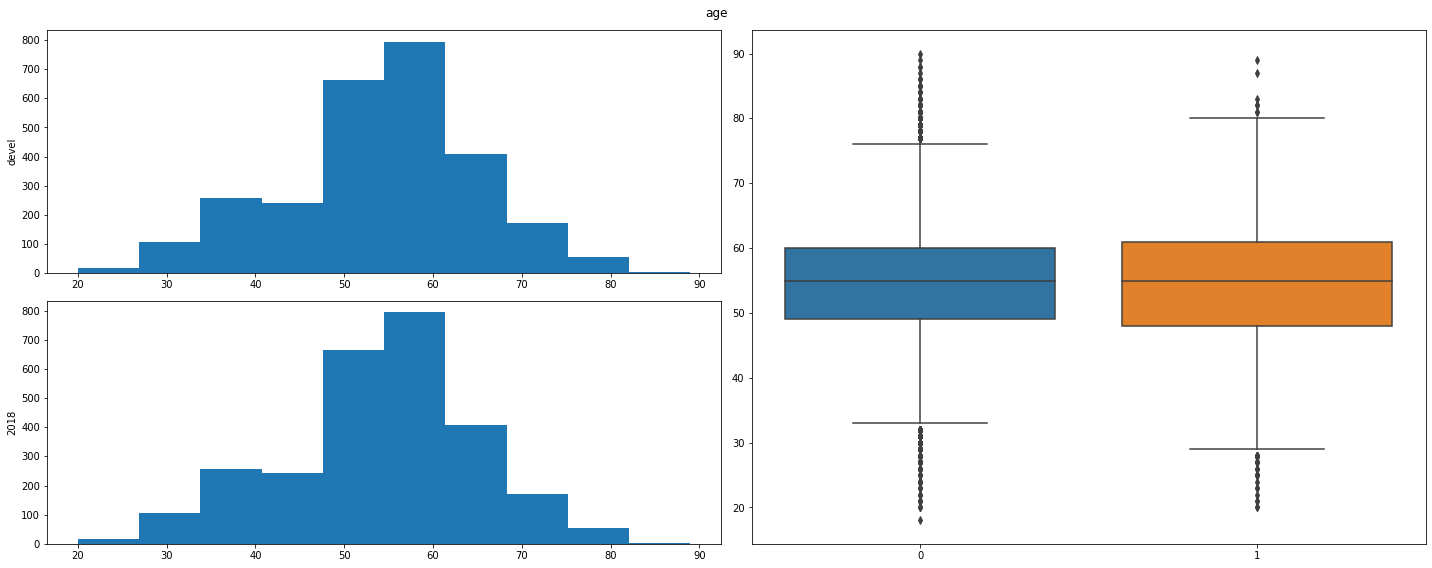

------------------------------------------------------------
BMI
------------------------------------------------------------


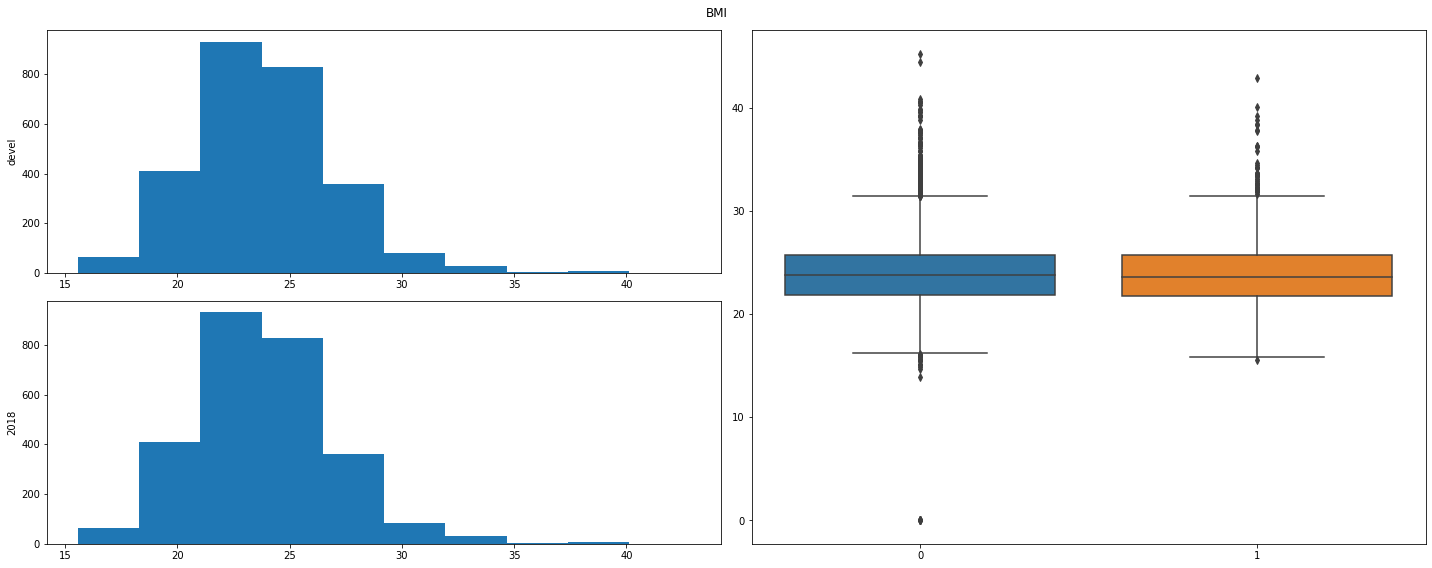

------------------------------------------------------------
FVC_MEAS
------------------------------------------------------------


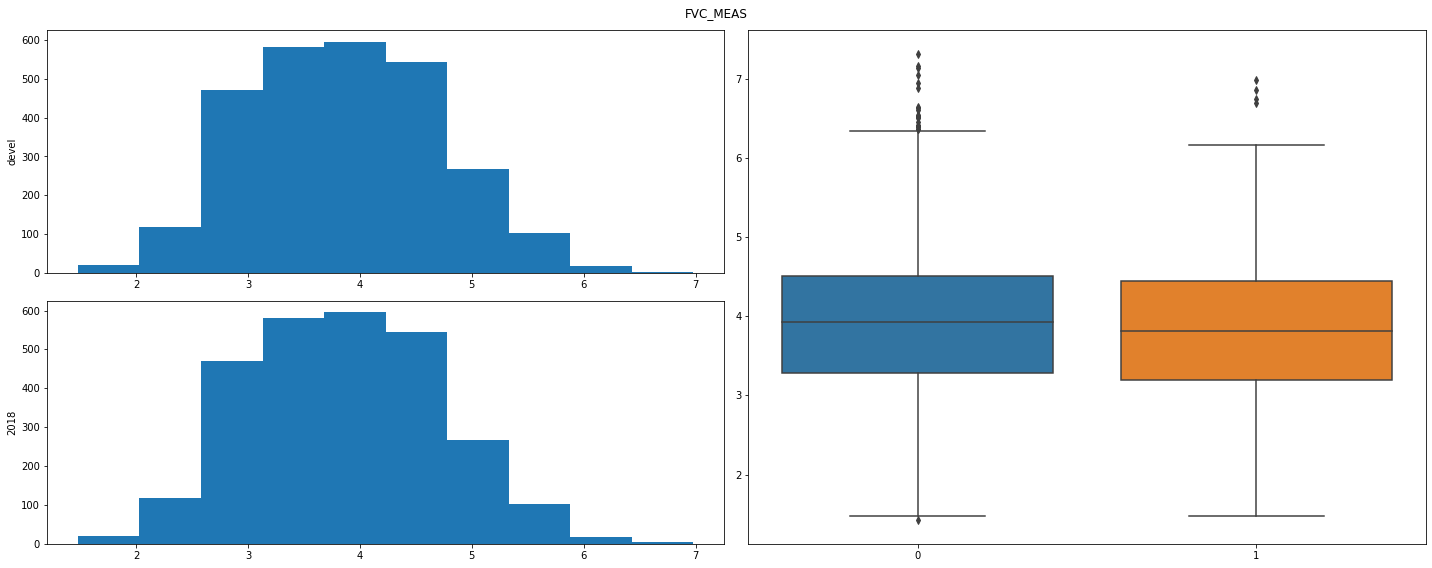

------------------------------------------------------------
FVC_%PRED
------------------------------------------------------------


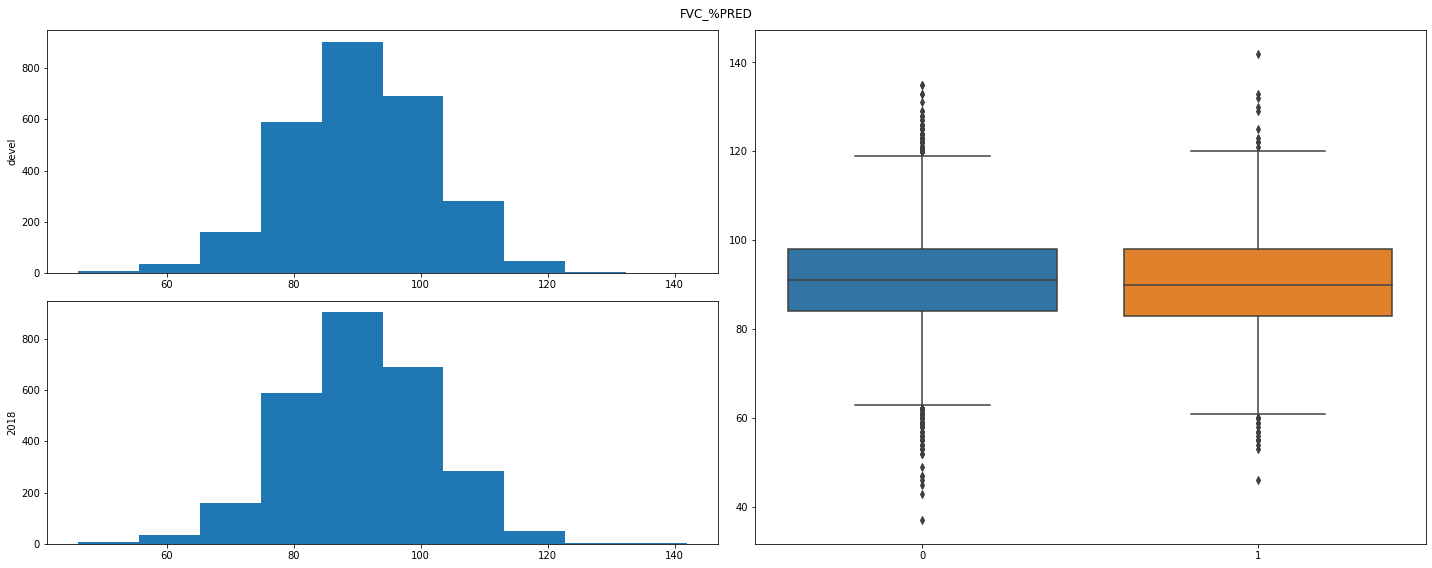

------------------------------------------------------------
FEV1_MEAS
------------------------------------------------------------


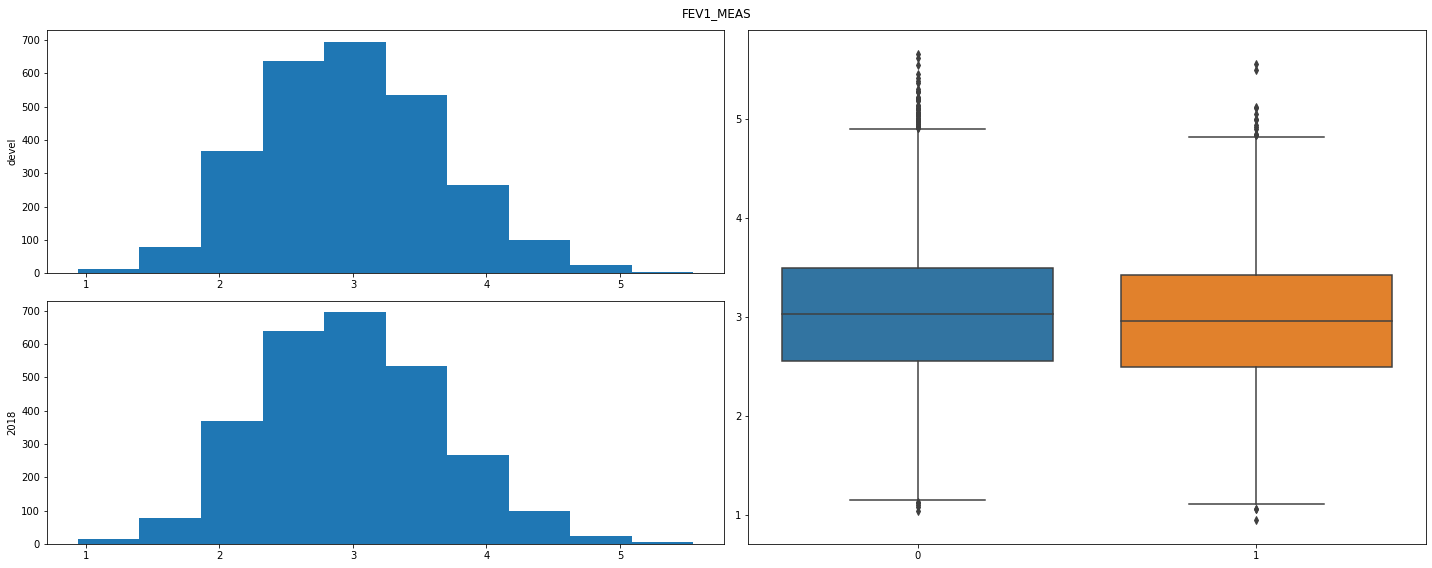

------------------------------------------------------------
FEV1_%PRED
------------------------------------------------------------


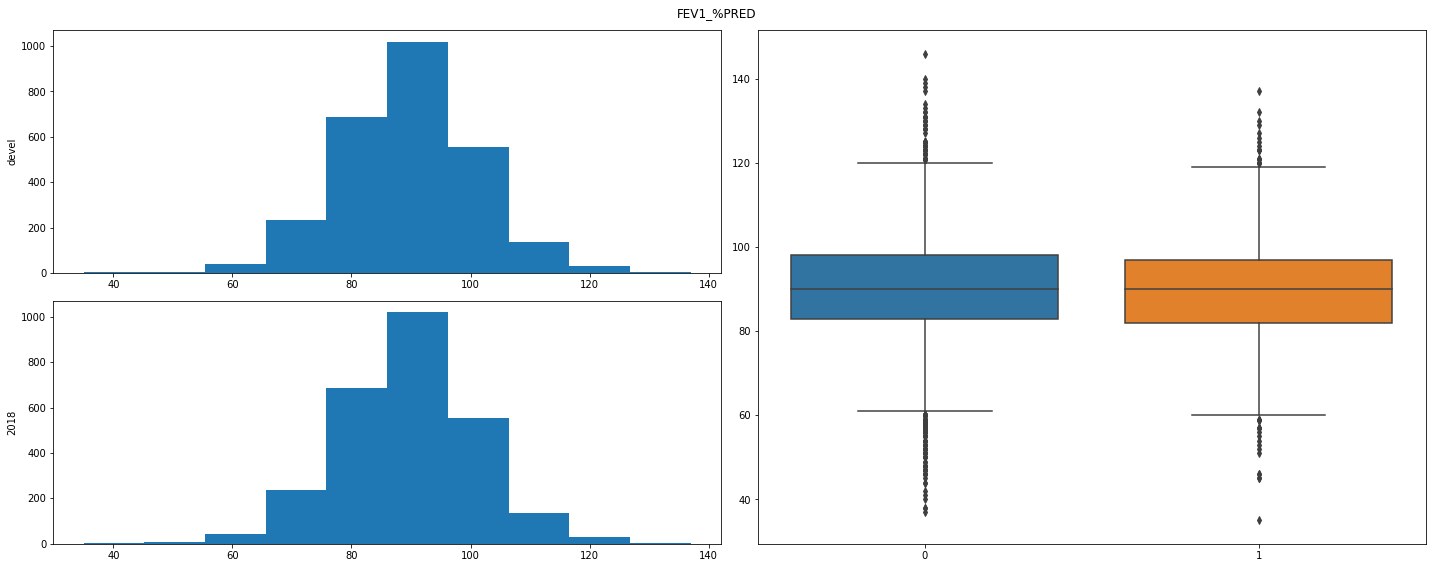

------------------------------------------------------------
FEV1/FVC_MEAS
------------------------------------------------------------


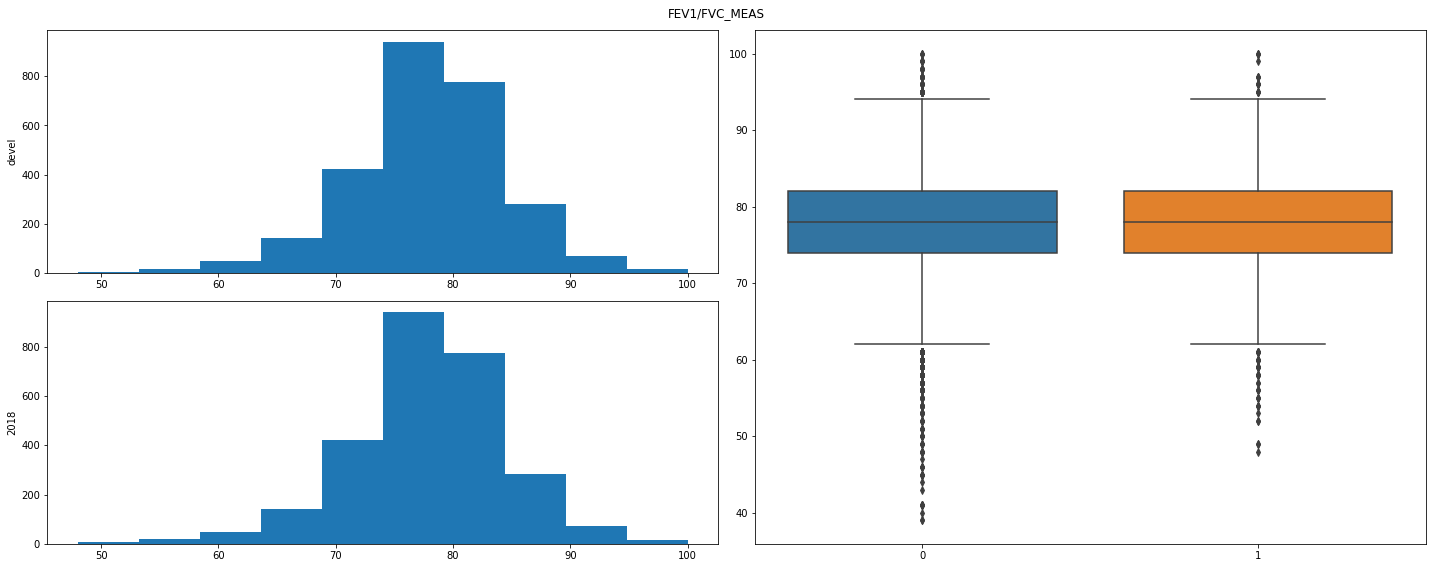

In [426]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
import seaborn as sns

list_set = ["devel", "2018"]
list_df = [df_devel, df_2018]
list_col = ["age", "BMI",  "FVC_MEAS","FVC_%PRED","FEV1_MEAS", "FEV1_%PRED", "FEV1/FVC_MEAS" ]
for col in list_col:
    print("--"*30)
    print(col)
    print("--"*30)

    #--
    fig = plt.figure(tight_layout=True,
                    figsize = (20,8))
    fig.suptitle(col)
    gs = gridspec.GridSpec(2, 2)
    for i, (_set, df) in enumerate(zip(list_set, list_df)):
        df_target = _df.copy()
        ax = fig.add_subplot(gs[i, 0])
        ax.hist(df_target[col])
        ax.set_ylabel(_set)
        
        
    ax = fig.add_subplot(gs[:, 1])
    sns.boxplot(data=[df_devel[col], df_2018[col]],
                ax = ax)
    fig.subplots_adjust(top=0.5)
#     df_devel.boxplot(column=[cdf_develol], by=["df_devel"], ax = ax)
    plt.tight_layout()
    plt.show()

In [405]:
list_col = ["age", "BMI", "FEV1_MEAS","FEV1_%PRED", "FVC_MEAS",  "FVC_%PRED", "FEV1/FVC_MEAS"]


for _df in [df_2018, df_devel]:
    display(_df[list_col].describe())
    
    
        
result =ttest_ind(df_2018[list_col], df_devel[list_col],
                 equal_var = False
                 )      

# print(result)
print("result of independent t test") 
display(pd.DataFrame(zip(result.statistic, result.pvalue), 
             index = list_col, 
             columns = ["statistic", "pvalue"]))

print("\n\n\n\==============")
list_statistic = []
list_pvalue = []
for _col in list_col:
    result =mannwhitneyu(df_2018[_col], df_devel[_col]
#              equal_var = False
             ) 
    list_statistic.append(result.statistic)
    list_pvalue.append(result.pvalue)
print("train vs", _compareset, "mann whitney u test")

display(pd.DataFrame(zip(list_statistic, list_pvalue), 
     index = list_col, 
     columns = ["statistic", "pvalue"]))


,age,BMI,FEV1_MEAS,FEV1_%PRED,FVC_MEAS,FVC_%PRED,FEV1/FVC_MEAS
count,2720.000000,2720.000000,2720.000000,2720.000000,2720.000000,2720.000000,2720.000000
mean,54.097794,23.849974,2.986379,89.570588,3.849125,90.437132,77.787132
std,10.899487,3.145947,0.671908,11.496109,0.844992,11.197338,6.659030
min,20.000000,15.570000,0.940000,35.000000,1.480000,46.000000,48.000000
25%,48.000000,21.759250,2.490000,82.000000,3.190000,83.000000,74.000000
50%,55.000000,23.622000,2.960000,90.000000,3.820000,90.000000,78.000000
75%,61.000000,25.688250,3.422500,97.000000,4.450000,98.000000,82.000000
max,89.000000,42.849000,5.550000,137.000000,6.980000,142.000000,100.000000


,age,BMI,FEV1_MEAS,FEV1_%PRED,FVC_MEAS,FVC_%PRED,FEV1/FVC_MEAS
count,13428.000000,13428.000000,13428.000000,13428.000000,13428.000000,13428.000000,13428.000000
mean,54.616473,23.906286,3.039415,90.415326,3.916973,91.001787,77.782321
std,9.748498,3.111947,0.665275,11.678690,0.827803,10.832124,6.770222
min,18.000000,0.000000,1.040000,37.000000,1.420000,37.000000,39.000000
25%,49.000000,21.899000,2.550000,83.000000,3.280000,84.000000,74.000000
50%,55.000000,23.795000,3.025000,90.000000,3.930000,91.000000,78.000000
75%,60.000000,25.709000,3.490000,98.000000,4.510000,98.000000,82.000000
max,90.000000,45.268000,5.660000,146.000000,7.320000,135.000000,100.000000


result of independent t test


,statistic,pvalue
age,-2.302325,0.021373
BMI,-0.852841,0.393800
FEV1_MEAS,-3.760255,0.000172
FEV1_%PRED,-3.485250,0.000497
FVC_MEAS,-3.831742,0.000129
FVC_%PRED,-2.411343,0.015941
FEV1/FVC_MEAS,0.034269,0.972664





\==============
train vs test mann whitney u test


,statistic,pvalue
age,18039083.5,0.157096
BMI,17943266.0,0.075214
FEV1_MEAS,17353132.0,0.000021
FEV1_%PRED,17398913.5,0.000049
FVC_MEAS,17350740.0,0.000020
FVC_%PRED,17668507.5,0.003698
FEV1/FVC_MEAS,18082510.5,0.208697


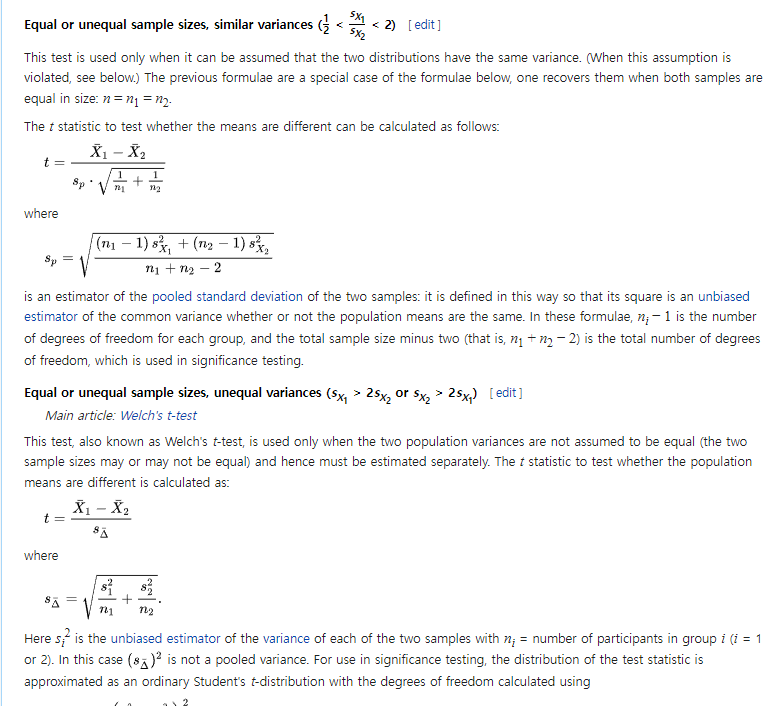

In [128]:
def check_welch_ttest(var_group1, var_group2):
    n1 = var_group1.shape[0]
    n2 = var_group2.shape[0]
    std1 = np.std(var_group1)
    std2 = np.std(var_group2)
    mean1 = np.mean(var_group1)
    mean2 = np.mean(var_group2)
    print("\nequal of unequal sample sizes, unequal variances")
    print("group1 n, std, mean", n1, std1, mean1)
    print("group2 n, std, mean",n2, std2, mean2)
    print("difference of means : ", mean1 - mean2)
    
    
    s_delta_bar = np.sqrt((std1)**2 / n1 + (std2)**2 / n2)  # is not a pooled variance
    print("s delta", s_delta_bar)
    
    
    
    df = (std1**2/n1  + std2/n2)**2 / ( (std1/n1)**2/(n1-1) + (std2/n2)**2/(n2-1) )
    print("degree of freedom", df)
    
    
    t = (mean1 - mean2) / s_delta_bar
    
    print("t", t)
    
    

def check_ttest_with_similar_variance(var_group1, var_group2):
    n1 = var_group1.shape[0]
    n2 = var_group2.shape[0]
    std1 = np.std(var_group1)
    std2 = np.std(var_group2)
    mean1 = np.mean(var_group1)
    mean2 = np.mean(var_group2)
    print("\nequal of unequal sample sizes, similar variances")
    print("group1 n, std, mean", n1, std1, mean1)
    print("group2 n, std, mean",n2, std2, mean2)
    print("difference of mean : ", mean1 - mean2)
    
    
    s_p = np.sqrt(    ((n1-1) *(std1)**2 + (n2-1) * (std2)**2) / (n1+n2-2))  # is a pooled variance
    print("s p", s_p)
    
    
    
    df = (n1+n2-2)
    print("degree of freedom", df)
    
    
    t = (mean1 - mean2) / (s_p * (np.sqrt(1/n1 + 1/n2)))
    print("t", t)

In [ ]:
# https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/





* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
age
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
0 0
ax fraction =  -200
ax fraction =  -300


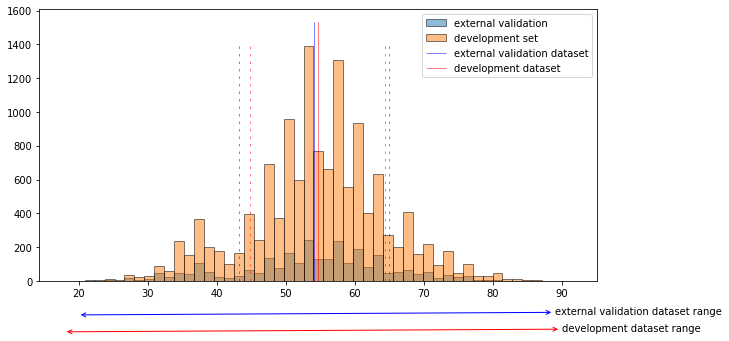

1.1179044811246635


________________
normality test
________________
0 normality pvalue:  4.5791864724868043e-10
1 normality pvalue:  1.0035950810490087e-33


________________
Levene’s Test for equal variance
________________
LeveneResult(statistic=52.26260521956346, pvalue=5.07273337338565e-13)
LeveneResult(statistic=55.892336853114685, pvalue=8.047304011361222e-14)


________________
ttest 
________________
Ttest_indResult(statistic=-2.302324591410663, pvalue=0.02137285347954519)


________________
t test statistics, assuming similar/non similar variance
________________

equal of unequal sample sizes, similar variances
group1 n, std, mean 2720 10.897483296289403 54.09779411764706
group2 n, std, mean 13428 9.74813455021312 54.61647304140602
difference of mean :  -0.5186789237589551
s p 9.950985545141624
degree of freedom 16146
t -2.478924236378189

equal of unequal sample sizes, unequal variances
group1 n, std, mean 2720 10.897483296289403 54.09779411764706
group2 n, std, mean 13428

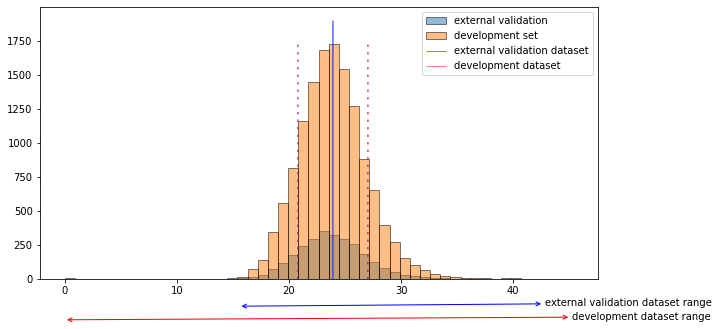

1.0107772561104427


________________
normality test
________________
0 normality pvalue:  7.258795401140847e-64
1 normality pvalue:  1.2178010364816704e-273


________________
Levene’s Test for equal variance
________________
LeveneResult(statistic=1.4408504398422872, pvalue=0.2300193812862876)
LeveneResult(statistic=1.742400953546236, pvalue=0.18685361092001454)


________________
ttest 
________________
Ttest_indResult(statistic=-0.8528410793857674, pvalue=0.3938001785379669)


________________
t test statistics, assuming similar/non similar variance
________________

equal of unequal sample sizes, similar variances
group1 n, std, mean 2720 3.1453683664027503 23.84997426470588
group2 n, std, mean 13428 3.111831362832991 23.906286267500747
difference of mean :  -0.056312002794864924
s p 3.1175042847031937
degree of freedom 16146
t -0.8590623044017264

equal of unequal sample sizes, unequal variances
group1 n, std, mean 2720 3.1453683664027503 23.84997426470588
group2 n, std, mean 134

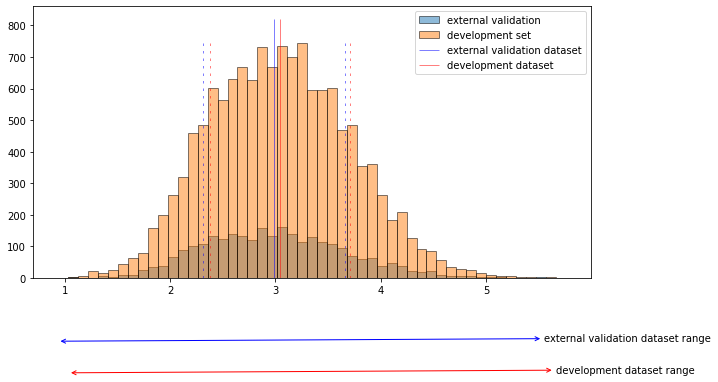

1.0098226785465148


________________
normality test
________________
0 normality pvalue:  5.8797965638122455e-08
1 normality pvalue:  1.5371953015918698e-20


________________
Levene’s Test for equal variance
________________
LeveneResult(statistic=0.19289523949932613, pvalue=0.6605236576563072)
LeveneResult(statistic=0.22563573688767682, pvalue=0.6347853428431878)


________________
ttest 
________________
Ttest_indResult(statistic=-3.760255218408533, pvalue=0.0001722445936257806)


________________
t test statistics, assuming similar/non similar variance
________________

equal of unequal sample sizes, similar variances
group1 n, std, mean 2720 0.6717846703883891 2.986378676470588
group2 n, std, mean 13428 0.6652501321868908 3.0394154006553475
difference of mean :  -0.053036724184759354
s p 0.6663550409015517
degree of freedom 16146
t -3.7853126184220045

equal of unequal sample sizes, unequal variances
group1 n, std, mean 2720 0.6717846703883891 2.986378676470588
group2 n, std, mea

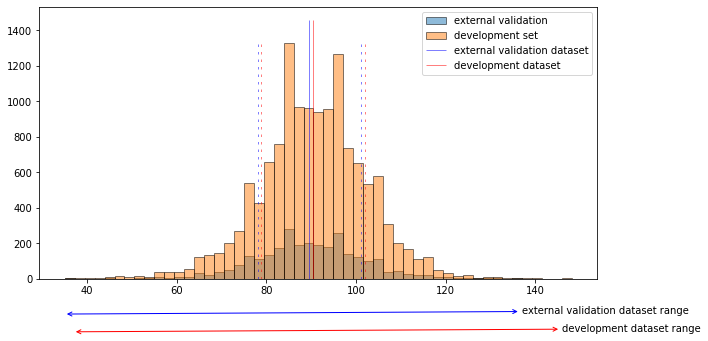

0.9842219698950938


________________
normality test
________________
0 normality pvalue:  1.5876666700374414e-07
1 normality pvalue:  3.865921132764979e-47


________________
Levene’s Test for equal variance
________________
LeveneResult(statistic=0.3244173323021263, pvalue=0.5689729289625938)
LeveneResult(statistic=0.2825599258996152, pvalue=0.5950355514656172)


________________
ttest 
________________
Ttest_indResult(statistic=-3.485250394506778, pvalue=0.0004970381702358419)


________________
t test statistics, assuming similar/non similar variance
________________

equal of unequal sample sizes, similar variances
group1 n, std, mean 2720 11.49399534825658 89.57058823529412
group2 n, std, mean 13428 11.678255210541279 90.41532618409293
difference of mean :  -0.8447379487988087
s p 11.647429804156545
degree of freedom 16146
t -3.449233940718157

equal of unequal sample sizes, unequal variances
group1 n, std, mean 2720 11.49399534825658 89.57058823529412
group2 n, std, mean 13428 1

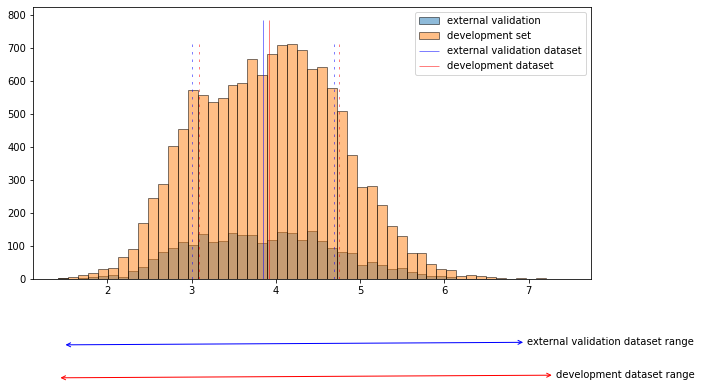

1.0206145966400402


________________
normality test
________________
0 normality pvalue:  1.366856139797525e-09
1 normality pvalue:  4.024992339134091e-30


________________
Levene’s Test for equal variance
________________
LeveneResult(statistic=3.0223276138952926, pvalue=0.08214457874907607)
LeveneResult(statistic=3.064165547897096, pvalue=0.08005523723545777)


________________
ttest 
________________
Ttest_indResult(statistic=-3.8317421314227116, pvalue=0.00012926881575821728)


________________
t test statistics, assuming similar/non similar variance
________________

equal of unequal sample sizes, similar variances
group1 n, std, mean 2720 0.8448366787650526 3.8491249999999995
group2 n, std, mean 13428 0.8277724829199337 3.9169734882335416
difference of mean :  -0.06784848823354217
s p 0.8306706536915112
degree of freedom 16146
t -3.8845619827693234

equal of unequal sample sizes, unequal variances
group1 n, std, mean 2720 0.8448366787650526 3.8491249999999995
group2 n, std, mea

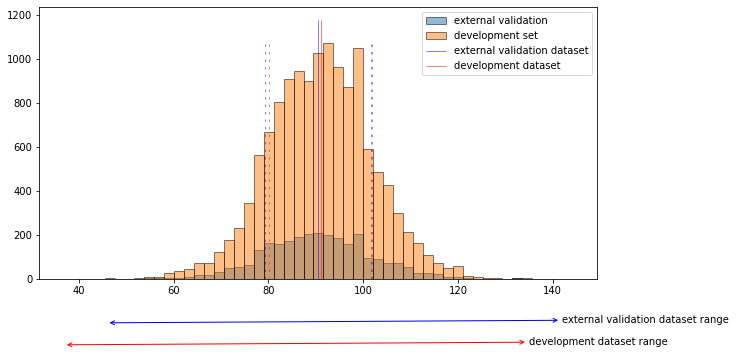

1.0335642362673563


________________
normality test
________________
0 normality pvalue:  0.0005129831527349761
1 normality pvalue:  2.527484675800863e-12


________________
Levene’s Test for equal variance
________________
LeveneResult(statistic=3.049054457107276, pvalue=0.08080318017458081)
LeveneResult(statistic=3.24450369798889, pvalue=0.07168204158074287)


________________
ttest 
________________
Ttest_indResult(statistic=-2.4113427712363484, pvalue=0.015940800243988338)


________________
t test statistics, assuming similar/non similar variance
________________

equal of unequal sample sizes, similar variances
group1 n, std, mean 2720 11.195279494191778 90.43713235294118
group2 n, std, mean 13428 10.83172104969763 91.00178731009831
difference of mean :  -0.5646549571571313
s p 10.893794198064985
degree of freedom 16146
t -2.4651010499593644

equal of unequal sample sizes, unequal variances
group1 n, std, mean 2720 11.195279494191778 90.43713235294118
group2 n, std, mean 13428 1

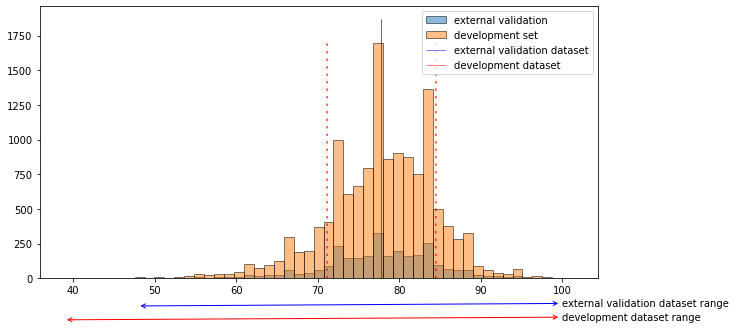

0.9834321062379473


________________
normality test
________________
0 normality pvalue:  8.512346410294619e-27
1 normality pvalue:  6.850420859924755e-294


________________
Levene’s Test for equal variance
________________
LeveneResult(statistic=0.015705843835316466, pvalue=0.9002694377752117)
LeveneResult(statistic=0.041507287194624556, pvalue=0.8385644289580378)


________________
ttest 
________________
Ttest_indResult(statistic=0.03426902121347277, pvalue=0.9726643629433799)


________________
t test statistics, assuming similar/non similar variance
________________

equal of unequal sample sizes, similar variances
group1 n, std, mean 2720 6.657805835356437 77.78713235294117
group2 n, std, mean 13428 6.7699699787364285 77.78232052427762
difference of mean :  0.004811828663548567
s p 6.751211926990516
degree of freedom 16146
t 0.03389683596283033

equal of unequal sample sizes, unequal variances
group1 n, std, mean 2720 6.657805835356437 77.78713235294117
group2 n, std, mean 1342

In [129]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html

from scipy.stats import ttest_ind, mannwhitneyu, normaltest, levene
# from statsmodels.stats.weightstats import ztest as ztest
# from statsmodels.stats.weightstats.CompareMeans import ztest_ind as ztest_int
# from statsmodels.stats import weightstats.ztest 
# from statsmodels.stats import weightstats.CompareMeans.ztest_ind # from distributions with different std

list_col = ["age", "BMI", "FEV1_MEAS","FEV1_%PRED", "FVC_MEAS",  "FVC_%PRED", "FEV1/FVC_MEAS"]



    
    
for _col in list_col:
    ymax = 0
    print("\n\n\n")
    print("* " * 40)
    print(_col)
    print("* " * 40)
    _min = min(df_2018[_col].min(), df_devel[_col].min())
    _max = max(df_2018[_col].max(), df_devel[_col].max())
    dic_mean = {}
    dic_std ={}
    dic_max = {}
    dic_min = {}
    dic_datagroup = {}
    
    print(df_2018[_col].isnull().sum(), df_devel[_col].isnull().sum())
    
    fig = plt.figure(figsize = (10, 5))
    ax = fig.add_subplot(1,1,1)

                     
    for i, (_df, _set) in enumerate(zip([df_2018, df_devel], ["external validation", "development set"])):
        
        hist = ax.hist(_df[_col],
                        alpha = 0.5, ec = "k", bins = np.arange(_min, _max* 1.02, (_max -_min) / 50), 
                      label = _set)
        ymax = max(ymax, np.max(hist[0]))
        dic_mean[i] = np.mean(_df[_col])
        dic_std[i] = np.std(_df[_col])
        dic_max[i] = np.max(_df[_col])
        dic_min[i] = np.min(_df[_col])
        dic_datagroup[i] = _df[_col] 

        
        
    for i, _set, _color in zip([0,1], ["external validation dataset", "development dataset"], ["blue", "red"]):
        ax.vlines(dic_mean[i], 
                  ymin = 0, ymax = ymax*1.1, 
                   linewidth = 0.5, 
                  color = _color,
                  label = _set)
        ax.vlines(dic_mean[i] -dic_std[i], 
                  ymin = 0, ymax = ymax,
                   linestyle = (0, (5,10)),
                   linewidth = 0.5, 
                  color = _color)
        ax.vlines(dic_mean[i] +dic_std[i], 
                  ymin = 0, ymax = ymax,
                   linestyle = (0, (5,10)),
                   linewidth = 0.5, 
                  color = _color)
        
        fraction = -1 * 100 * (i+1) - 100
        print("ax fraction = ", fraction)
        ax.annotate(_set+" range", 
                    xy=(dic_min[i], fraction),  
                    xytext=(dic_max[i], fraction), 
                    xycoords='data',
                    arrowprops=dict(arrowstyle="<->", color=_color),
                   annotation_clip = False)

#         ax.arrow()
                

    ax.legend()
    col_for_filename = _col.replace("%", "percent_").replace("/", "_per_")
#     filename = os.path.join(PATH_histogram, col_for_filename)
#     print(filename)
#     plt.savefig(filename, dpi = 300, bbox_inches = "tight")
    plt.show()
    
    
    
    

    
    
    #-------calculating manually
    print(np.std(dic_datagroup[0]) / np.std(dic_datagroup[1]))
    print("\n")
    print("________________")
    print("normality test")
    print("________________")
    
    for i in [0,1]:
        normal_result = normaltest(dic_datagroup[i])
        print(i, "normality pvalue: " , normal_result.pvalue)    
    print("\n")
    print("________________")
    print("Levene’s Test for equal variance")
    print("________________")
    levene_result = levene(dic_datagroup[0],dic_datagroup[1], center = "median")
    print(levene_result)
    levene_result = levene(dic_datagroup[0],dic_datagroup[1], center = "mean")
    print(levene_result)
    
    
    #------ ind_ttest using scipy
    print("\n")
    print("________________")
    print("ttest ")
    print("________________")
    result =ttest_ind(dic_datagroup[0], dic_datagroup[1],
                 equal_var = False
                 )
    print(result)
    

    
    
    print("\n")  
    print("________________")
    print("t test statistics, assuming similar/non similar variance")
    print("________________")
    check_ttest_with_similar_variance(dic_datagroup[0],dic_datagroup[1])
    check_welch_ttest(dic_datagroup[0],dic_datagroup[1])
    print("\n")
    print("________________")
    print("mann whitney U test")
    print("________________")
    static, pvalue = mannwhitneyu(dic_datagroup[0],dic_datagroup[1])
    print("static, pvalue", static, pvalue)
    
    
#     print("\nztest")
#     static, pvalue = ztest(dic_datagroup[0],dic_datagroup[1])
#     print(static, pvalue)
    
#     print("\nztest")
#     static, pvalue = ztest_ind(dic_datagroup[0],dic_datagroup[1],
#                                                        usevar = "pooled")
#     print(static, pvalue)
    
    
#     summary, results = rp.ttest(group1 = dic_datagroup[0], group1_name= "external",
#          group2 = dic_datagroup[1], group2_name= "development")
#     print(summary)
#     print(results)




    
#     break




F

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
age
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
normality pvalue:  0.09647673825391853
normality pvalue:  4.163878423071049e-12


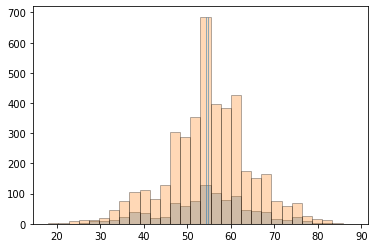

Ttest_indResult(statistic=-1.017363307346264, pvalue=0.30915807343963825)
1.086287802784405

equal of unequal sample sizes, similar variances
group1 n, std, mean 977 10.402438359488293 54.37871033776868
group2 n, std, mean 4190 9.576134734114161 54.74940334128878
difference of mean :  -0.3706930035201026
s p 9.737650978720216
degree of freedom 5165
t -1.0715075795510538

equal of unequal sample sizes, unequal variances
group1 n, std, mean 977 10.402438359488293 54.37871033776868
group2 n, std, mean 4190 9.576134734114161 54.74940334128878
difference of means :  -0.3706930035201026
s delta 0.3642034671215704
degree of freedom 108848.75749324207
t -1.017818436627804

mann whitney
static, pvalue 2021226.0 0.2709900055372413
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
BMI
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
normality pvalue:  1.2761477046542552e-31
normality pvalue:  2.2990246367725122e-145


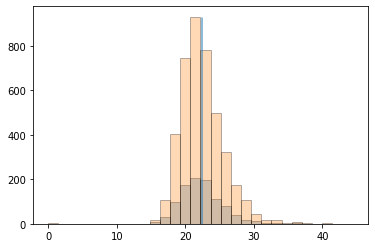

Ttest_indResult(statistic=-0.5861177247760974, pvalue=0.5578834606563396)
0.9516022146975974

equal of unequal sample sizes, similar variances
group1 n, std, mean 977 2.9747191932807064 22.35302354145343
group2 n, std, mean 4190 3.1260112128112483 22.415601909307878
difference of mean :  -0.06257836785444582
s p 3.097988655185746
degree of freedom 5165
t -0.5685641486636814

equal of unequal sample sizes, unequal variances
group1 n, std, mean 977 2.9747191932807064 22.35302354145343
group2 n, std, mean 4190 3.1260112128112483 22.415601909307878
difference of means :  -0.06257836785444582
s delta 0.10672149844802803
degree of freedom 9978.413739742107
t -0.5863707759399636

mann whitney
static, pvalue 2031240.5 0.3553501446603591
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
FEV1_MEAS
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
normality pvalue:  0.7642581699586801
normality pvalue:  0.00031736680278297483


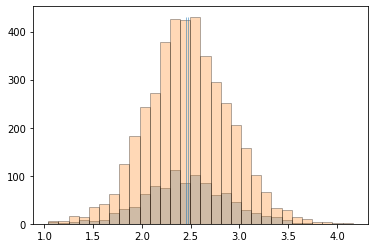

Ttest_indResult(statistic=-1.075850782486125, pvalue=0.2821716958120644)
1.00472100348707

equal of unequal sample sizes, similar variances
group1 n, std, mean 977 0.4273227511419252 2.4550153531218015
group2 n, std, mean 4190 0.4253148383071744 2.4713412887828157
difference of mean :  -0.016325935661014146
s p 0.42569498765353453
degree of freedom 5165
t -1.0794800155009452

equal of unequal sample sizes, unequal variances
group1 n, std, mean 977 0.4273227511419252 2.4550153531218015
group2 n, std, mean 4190 0.4253148383071744 2.4713412887828157
difference of means :  -0.016325935661014146
s delta 0.015168256306026303
degree of freedom 419.1151913819618
t -1.0763225074544593

mann whitney
static, pvalue 2006792.5 0.17024314350070596
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
FEV1_%PRED
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
normality pvalue:  0.0002718790812758443
normality pvalue:  4.6650335276650467e-11


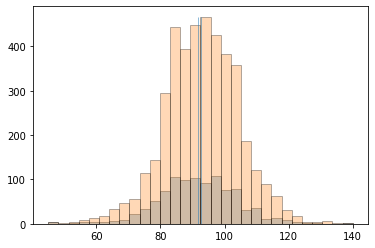

Ttest_indResult(statistic=-2.4712597013499105, pvalue=0.013578423044043164)
1.0205749093227128

equal of unequal sample sizes, similar variances
group1 n, std, mean 977 11.840374604752895 91.78300921187308
group2 n, std, mean 4190 11.601671270373048 92.81909307875895
difference of mean :  -1.0360838668858747
s p 11.64715253195091
degree of freedom 5165
t -2.503860971695841

equal of unequal sample sizes, unequal variances
group1 n, std, mean 977 11.840374604752895 91.78300921187308
group2 n, std, mean 4190 11.601671270373048 92.81909307875895
difference of means :  -1.0360838668858747
s delta 0.41906880740161784
degree of freedom 140453.10867657108
t -2.472347854544411

mann whitney
static, pvalue 1935499.0 0.003999197275681775
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
FVC_MEAS
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
normality pvalue:  0.16946884386007144
normality pvalue:  0.0006289553700056752


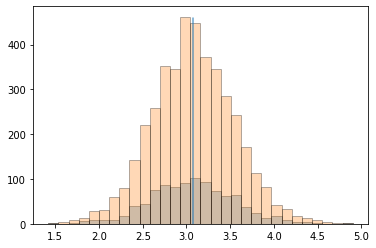

Ttest_indResult(statistic=-0.3824154243493601, pvalue=0.7022095444576029)
1.0216825002074479

equal of unequal sample sizes, similar variances
group1 n, std, mean 977 0.4773341209021701 3.068628454452405
group2 n, std, mean 4190 0.467203970710323 3.0750906921241055
difference of mean :  -0.00646223767170051
s p 0.4691349684638451
degree of freedom 5165
t -0.38772176724385443

equal of unequal sample sizes, unequal variances
group1 n, std, mean 977 0.4773341209021701 3.068628454452405
group2 n, std, mean 4190 0.467203970710323 3.0750906921241055
difference of means :  -0.00646223767170051
s delta 0.016891035814505025
degree of freedom 480.04144679467834
t -0.38258385943099604

mann whitney
static, pvalue 2027054.5 0.3189552755175976
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
FVC_%PRED
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
normality pvalue:  0.007437526665835644
normality pvalue:  8.023809283228832e-07


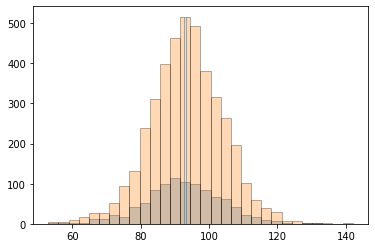

Ttest_indResult(statistic=-1.3714621316283073, pvalue=0.17044869205849916)
1.0550280605870335

equal of unequal sample sizes, similar variances
group1 n, std, mean 977 11.300827602544427 92.79119754350052
group2 n, std, mean 4190 10.711400032579679 93.33675417661098
difference of mean :  -0.5455566331104649
s p 10.825240318337558
degree of freedom 5165
t -1.4185261839622176

equal of unequal sample sizes, unequal variances
group1 n, std, mean 977 11.300827602544427 92.79119754350052
group2 n, std, mean 4190 10.711400032579679 93.33675417661098
difference of means :  -0.5455566331104649
s delta 0.39761538059762375
degree of freedom 128108.74951238067
t -1.372071252099158

mann whitney
static, pvalue 1980891.0 0.05812114726719702
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
FEV1/FVC_MEAS
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
normality pvalue:  4.870852647476406e-09
normality pvalue:  7.667082044109462e-27


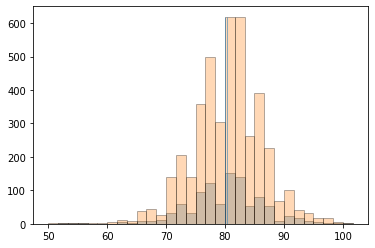

Ttest_indResult(statistic=-1.6876081956649578, pvalue=0.09170352492145468)
1.0289113276320232

equal of unequal sample sizes, similar variances
group1 n, std, mean 977 6.039907969721292 79.93961105424769
group2 n, std, mean 4190 5.8701928995395285 80.3
difference of mean :  -0.3603889457523053
s p 5.90263690559986
degree of freedom 5165
t -1.7185432052262437

equal of unequal sample sizes, unequal variances
group1 n, std, mean 977 6.039907969721292 79.93961105424769
group2 n, std, mean 4190 5.8701928995395285 80.3
difference of means :  -0.3603889457523053
s delta 0.21345593529621987
degree of freedom 37873.742996503475
t -1.6883528923765068

mann whitney
static, pvalue 1968330.5 0.030592597679128086

M

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
age
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
normality pvalue:  4.971064515553761e-09
normality pvalue:  6.98523134659995e-23


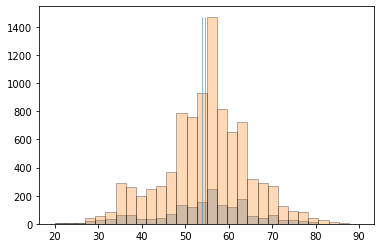

Ttest_indResult(statistic=-2.150969783566568, pvalue=0.03158342364572735)
1.1361608876337619

equal of unequal sample sizes, similar variances
group1 n, std, mean 1743 11.162282677173039 53.940332759609866
group2 n, std, mean 9238 9.824561643219642 54.556180991556616
difference of mean :  -0.6158482319467495
s p 10.048706495923655
degree of freedom 10979
t -2.3468226127574123

equal of unequal sample sizes, unequal variances
group1 n, std, mean 1743 11.162282677173039 53.940332759609866
group2 n, std, mean 9238 9.824561643219642 54.556180991556616
difference of means :  -0.6158482319467495
s delta 0.2862382464629312
degree of freedom 222396.76988690492
t -2.1515232138151874

mann whitney
static, pvalue 7950141.0 0.2030742453962351
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
BMI
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
normality pvalue:  2.0407765694811137e-64
normality pvalue:  9.00303493554378e-250


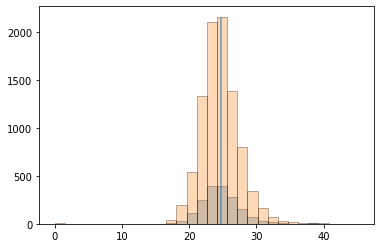

Ttest_indResult(statistic=1.4033946294763595, pvalue=0.1606277561721724)
1.0205904956955532

equal of unequal sample sizes, similar variances
group1 n, std, mean 1743 2.9186685190187385 24.689056798623064
group2 n, std, mean 9238 2.8597841458729305 24.582403117557913
difference of mean :  0.10665368106515061
s p 2.8692077876969777
degree of freedom 10979
t 1.4234118438553303

equal of unequal sample sizes, unequal variances
group1 n, std, mean 1743 2.9186685190187385 24.689056798623064
group2 n, std, mean 9238 2.8597841458729305 24.582403117557913
difference of means :  0.10665368106515061
s delta 0.0759778367907549
degree of freedom 16671.41129695907
t 1.4037472711795922

mann whitney
static, pvalue 7935342.0 0.1705277479837139
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
FEV1_MEAS
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
normality pvalue:  0.008863696353566082
normality pvalue:  1.3788638040120321e-07


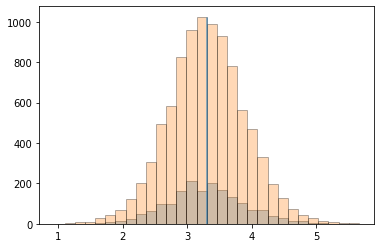

Ttest_indResult(statistic=-0.8268805039756535, pvalue=0.408385943071805)
1.009203998444027

equal of unequal sample sizes, similar variances
group1 n, std, mean 1743 0.5957587339629677 3.2842226047045324
group2 n, std, mean 9238 0.5903253800832121 3.29707187702966
difference of mean :  -0.012849272325127448
s p 0.5911908045550378
degree of freedom 10979
t -0.8322764190956563

equal of unequal sample sizes, unequal variances
group1 n, std, mean 1743 0.5957587339629677 3.2842226047045324
group2 n, std, mean 9238 0.5903253800832121 3.29707187702966
difference of means :  -0.012849272325127448
s delta 0.01553556181297253
degree of freedom 1060.2354598489228
t -0.8270877152571353

mann whitney
static, pvalue 7903084.0 0.11164321552303402
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
FEV1_%PRED
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
normality pvalue:  0.00010886649015914713
normality pvalue:  1.0571027807300083e-39


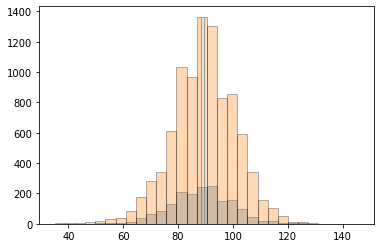

Ttest_indResult(statistic=-3.4070533026424754, pvalue=0.0006670452952122994)
0.9614671617343775

equal of unequal sample sizes, similar variances
group1 n, std, mean 1743 11.104046915527062 88.33046471600689
group2 n, std, mean 9238 11.54906517607593 89.32507036155012
difference of mean :  -0.9946056455432313
s p 11.479607192641243
degree of freedom 10979
t -3.3177267856555592

equal of unequal sample sizes, unequal variances
group1 n, std, mean 1743 11.104046915527062 88.33046471600689
group2 n, std, mean 9238 11.54906517607593 89.32507036155012
difference of means :  -0.9946056455432313
s delta 0.2918532335794329
degree of freedom 220843.3516389877
t -3.4078966107207176

mann whitney
static, pvalue 7603999.0 0.0001152232673827202
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
FVC_MEAS
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
normality pvalue:  0.0014595533029496148
normality pvalue:  1.5417312440959215e-16


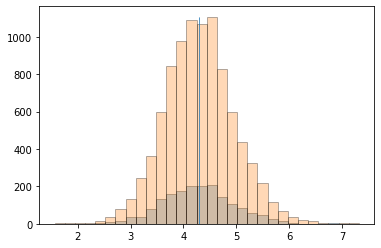

Ttest_indResult(statistic=-0.696844655237308, pvalue=0.48596733326022445)
1.0270259614667643

equal of unequal sample sizes, similar variances
group1 n, std, mean 1743 0.6732407765805757 4.28661503155479
group2 n, std, mean 9238 0.6555245941583362 4.298819008443386
difference of mean :  -0.012203976888596202
s p 0.6583673800450176
degree of freedom 10979
t -0.7098225602643952

equal of unequal sample sizes, unequal variances
group1 n, std, mean 1743 0.6732407765805757 4.28661503155479
group2 n, std, mean 9238 0.6555245941583362 4.298819008443386
difference of means :  -0.012203976888596202
s delta 0.017508789605883857
degree of freedom 1271.1788150428931
t -0.6970200204184894

mann whitney
static, pvalue 7945699.0 0.1930331555583878
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
FVC_%PRED
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
normality pvalue:  0.051594631647290966
normality pvalue:  3.4591308156826157e-09


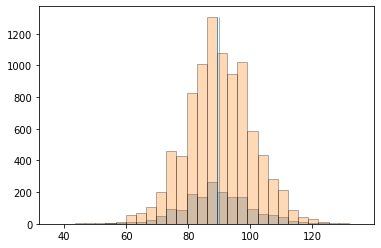

Ttest_indResult(statistic=-2.90202390908551, pvalue=0.0037411346379238267)
1.0183191461837267

equal of unequal sample sizes, similar variances
group1 n, std, mean 1743 10.915859528912334 89.1176133103844
group2 n, std, mean 9238 10.719487667320044 89.94273652305694
difference of mean :  -0.825123212672537
s p 10.750884722391078
degree of freedom 10979
t -2.9389441065419963

equal of unequal sample sizes, unequal variances
group1 n, std, mean 1743 10.915859528912334 89.1176133103844
group2 n, std, mean 9238 10.719487667320044 89.94273652305694
difference of means :  -0.825123212672537
s delta 0.28425542547251303
degree of freedom 213295.08389452114
t -2.902752731283663

mann whitney
static, pvalue 7681028.5 0.0011504005875392184
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
FEV1/FVC_MEAS
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
normality pvalue:  1.4768627517182538e-17
normality pvalue:  1.0982093814547365e-233


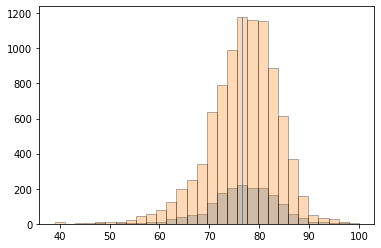

Ttest_indResult(statistic=-0.34117583824949294, pvalue=0.733000109991798)
0.9768696026332692

equal of unequal sample sizes, similar variances
group1 n, std, mean 1743 6.68367414165022 76.5806081468732
group2 n, std, mean 9238 6.841930717911147 76.6403983546222
difference of mean :  -0.05979020774900334
s p 6.8170659145384755
degree of freedom 10979
t -0.3358530494644887

equal of unequal sample sizes, unequal variances
group1 n, std, mean 1743 6.68367414165022 76.5806081468732
group2 n, std, mean 9238 6.841930717911147 76.6403983546222
difference of means :  -0.05979020774900334
s delta 0.17520393864115585
degree of freedom 81804.76929469978
t -0.3412606372477888

mann whitney
static, pvalue 7906054.0 0.11608627880364036


In [172]:
list_col = ["age", "BMI", "FEV1_MEAS","FEV1_%PRED", "FVC_MEAS",  "FVC_%PRED", "FEV1/FVC_MEAS"]



    
for _sex in ["F", "M"]:
    print("==" * 40, "\n")
    
    print(_sex)
    print("\n", "==" * 40)
    for _col in list_col:
        ymax = 0
        print("* " * 40)
        print(_col)
        print("* " * 40)
        _min = min(df_2018[df_2018["sex"] ==_sex][_col].min(), df_devel[df_devel["sex"] ==_sex][_col].min())
        _max = max(df_2018[df_2018["sex"] ==_sex][_col].max(), df_devel[df_devel["sex"] ==_sex][_col].max())
        dic_mean = {}
        dic_datagroup = {}
        for i, _df in enumerate([df_2018[df_2018["sex"] ==_sex], df_devel[df_devel["sex"] ==_sex]]):

            hist = plt.hist(_df[_col],
                            alpha = 0.3, ec = "k", bins = np.arange(_min, _max* 1.02, (_max -_min) / 30))
            ymax = max(ymax, np.max(hist[0]))
            dic_mean[i] = np.mean(_df[_col])
            dic_datagroup[i] = _df[_col]  
            normal_result = normaltest(_df[_col])
            print("normality pvalue: " , normal_result.pvalue)

        for i in [0,1]:
            plt.vlines(dic_mean[i], 
                      ymin = 0, ymax = ymax, 
                       linewidth = 0.5)
        plt.show()




        #------ ind_ttest using scipy
        result =ttest_ind(dic_datagroup[0], 
                          dic_datagroup[1],
                         equal_var = False
                     )
        print(result)


        #-------calculating manually
        print(np.std(dic_datagroup[0]) / np.std(dic_datagroup[1]))
        check_ttest_with_similar_variance(dic_datagroup[0],dic_datagroup[1])
        check_welch_ttest(dic_datagroup[0],dic_datagroup[1])
        print("\nmann whitney")
        static, pvalue = mannwhitneyu(dic_datagroup[0],dic_datagroup[1])
        print("static, pvalue", static, pvalue)

## 4) PFT risk group

In [ ]:
    
from scipy.stats import chi2_contingency

list_set = ["train", "valid", "test"]
list_col = ["FEV1/FVC_MEAS", "FVC_%PRED", "FEV1_%PRED"]
list_cutoff = [70, 80, 80]
dict_dist = dict()

for _col, _cutoff in zip(list_col, list_cutoff):
    
    print("="*40)
    print(_col)
    print("="*40)
        
    for _set in list_set:
        df_target = df_devel[df_devel["set_split"] == _set]
        dict_dist[_set] =dict() 
        
        n_target_positive = df_target[df_target[_col] <_cutoff].shape[0]
        n_target_negative =  df_target.shape[0] - df_target[df_target[_col] <_cutoff].shape[0]
        
        dict_dist[_set]["under cutoff"] = n_target_positive
        dict_dist[_set]["equal/over cutoff"] = n_target_negative

    df_dist = pd.DataFrame.from_dict(dict_dist, orient = "columns")
    df_ratio = (df_dist/df_dist.sum(axis = 0) * 100).round(3)
    display(df_dist)
    display(df_ratio)

    print(f"Chi 2 test of 2*3 table for {_col}")
    
    chi2, p, dof, ex = chi2_contingency(df_dist,
                                   correction = False)
    
    print(_col)
    print(p)
    
    
    for _compareset in  "valid", "test":
        print("\n")
        print("-"*40)
        df_contingency = pd.concat([df_dist["train"],\
                                    df_dist[_compareset]], 
                                  axis = 1)
        
        display(df_contingency)

        chi2, p, dof, ex = chi2_contingency(df_contingency,
                                           correction = False)
        print(_col, "train vs", _compareset)
        print("chi2:\t\t", chi2)
        print("p:\t\t", p)
        print("dof:\t\t", dof)
        print("ex:\t\t", ex)
    
    
    print("\n\n\n")
    
    

# concat df 2018 and df_devel

In [176]:
np.intersect1d(df_devel.keys(), df_2018.keys()).shape, df_devel.shape, df_2018.shape

((62,), (13428, 66), (2720, 90))

In [177]:
np.intersect1d(df_devel.keys(), df_2018.keys()).tolist()

array(['AC', 'BMI', 'DBP', 'EXCEL', 'FEV1/FVC_MEAS', 'FEV1/FVC_PRED',
       'FEV1_%PRED', 'FEV1_MEAS', 'FEV1_PRED', 'FVC_%PRED', 'FVC_MEAS',
       'FVC_PRED', 'HE0108(R5253A)검사접수번호', 'HE0109(R5253)검사접수번호', 'Ht',
       'ID_path', 'PYTHON', 'Q0002 귀하께서는 암을 진단 받은 적이 있습니까?',
       'Q0003 진단 받은 암을 선택해 주시겠습니까? (복수 응답 가능)',
       'Q0012 복용/주사 중인 약을 선택해 주시겠습니까? (복수 응답 가능)',
       'Q0016 시술 혹은 수술을 선택해주시겠습니까?(복수 응답 가능)', 'Q0047 귀하는 담배를 피운적이 있습니까?',
       'Q0048 처음 흡연을 시작한 연령은 몇 세입니까?', 'Q0049 흡연을 중단한 연령은 몇 세입니까?',
       'Q0050 하루 평균 흡연량은 얼마입니까? (현재 끊으신분도 과거 하루 평균 흡연량 표시바랍니다)',
       'Q0089 숨찬 증상이 있습니까?', 'Q0090 상기도 및 호흡기계 증상이 있습니까?',
       'Q0211 흉부 통증이 있습니까?',
       'Q0214 폐질환, 신장/요로/전립선질환, 간/담도질환, 식도/위/대장질환 및 갑상선 질환이 있습니까?',
       'Q0229 과거력(폐,비뇨기,소화기,갑상선) 을 선택해 주시겠습니까? (복수 응답 가능)', 'R5253 결과본문',
       'R5253 결론', 'R5253 접수일자', 'R5253A 결과본문', 'R5253A 결론',
       'R5253A 접수일자', 'S2001 결론', 'S2001 접수일자', 'S2002 결론', 'S2002 접수일자',
       'SBP', 'Wt', 'age', 'body_size_y_3d', 'check_d

In [180]:
list_intersect = np.intersect1d(df_devel.keys(), df_2018.keys()).tolist()
df_new = pd.concat([df_devel[list_intersect],
                    df_2018[list_intersect]],
                   axis = 0
                  )

df_new.shape

(16148, 62)

In [192]:
df_pivot = pd.pivot_table(df_new,
              index = "examdate_year", 
               values = "연구번호",
              columns = "sex",
              aggfunc = "count")
display(df_pivot)

sex,F,M
examdate_year,,
2015,1587,3928
2016,1474,3227
2017,1129,2083
2018,977,1743


<BarContainer object of 4 artists>

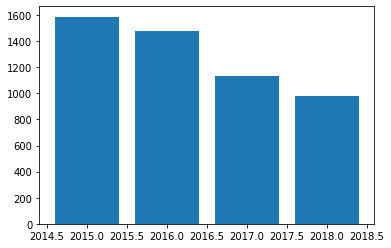

In [196]:
plt.bar(df_pivot.index, df_pivot["F"])


<BarContainer object of 4 artists>

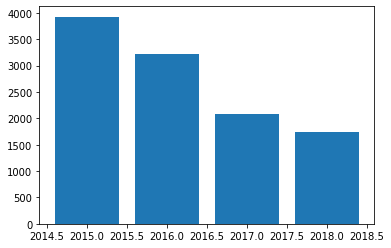

In [197]:
plt.bar(df_pivot.index, df_pivot["M"])

In [199]:
df_new["age"].describe()

count    16148.000000
mean        54.529106
std          9.953236
min         18.000000
25%         49.000000
50%         55.000000
75%         61.000000
max         90.000000
Name: age, dtype: float64

In [204]:
df_new["age_binned"] = pd.cut(df_new["age"], bins = np.arange(18, 101, 10))

In [206]:
 pd.pivot_table(df_new,
              index = "examdate_year", 
               values = "연구번호",
              columns = ["sex","age_binned", ],
              aggfunc = "count")

sex                  F                                                        \
age_binned    (18, 28] (28, 38] (38, 48] (48, 58] (58, 68] (68, 78] (78, 88]   
examdate_year                                                                  
2015               3.0     56.0    247.0    795.0    397.0     84.0      5.0   
2016               7.0     97.0    221.0    683.0    362.0     93.0     11.0   
2017              16.0     99.0    158.0    457.0    287.0     93.0     18.0   
2018               9.0     85.0    149.0    413.0    240.0     75.0      6.0   

sex                  M                                                        \
age_binned    (18, 28] (28, 38] (38, 48] (48, 58] (58, 68] (68, 78] (78, 88]   
examdate_year                                                                  
2015              15.0    208.0    541.0   1927.0    966.0    243.0     28.0   
2016              13.0    235.0    481.0   1412.0    868.0    188.0     28.0   
2017              19.0    268.0    321.0    788.0    533.0    132.0     22.0   
2018              28.0    196.0    230.0    676.0    465.0    134.0     13.0   

sex                     
age_binned    (88, 98]  
examdate_year           
2015               NaN  
2016               2.0  
2017               NaN  
2018               1.0

# CHECKING SMOKING STATUS

age_binned,"(18, 28]","(28, 38]","(38, 48]","(48, 58]","(58, 68]","(68, 78]","(78, 88]"
examdate_year,,,,,,,
2015,0.19,3.53,15.56,50.09,25.02,5.29,0.32
2016,0.47,6.58,14.99,46.34,24.56,6.31,0.75
2017,1.42,8.78,14.01,40.51,25.44,8.24,1.60
2018,0.92,8.70,15.25,42.27,24.56,7.68,0.61


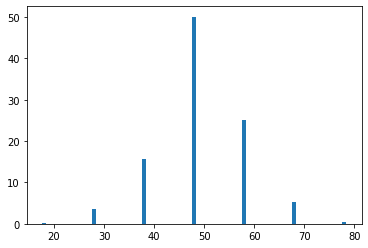

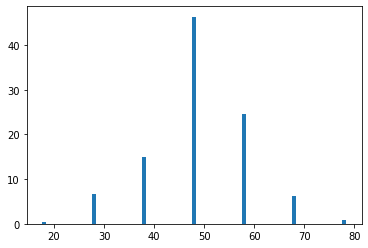

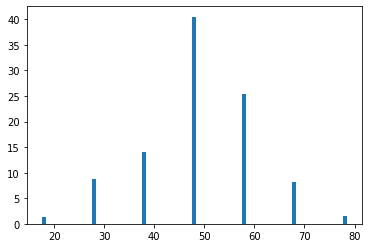

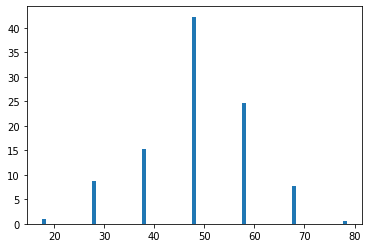

In [349]:
df_F = df_new[df_new["sex"] =="F"]

df_cm =pd.crosstab(df_F["examdate_year"], df_F["age_binned"],normalize='index') * 100
display(df_cm.round(2))
for _year in df_cm.index:
    
    list_left = [_interval.left for _interval in df_cm.keys().tolist()]
    plt.bar(list_left, df_cm.loc[_year, :].values)
    plt.show()

In [350]:
df_F['Q0047 귀하는 담배를 피운적이 있습니까?'].value_counts(dropna = False)

없음                 4760
현재 피운다              204
과거에 피웠으나 현재 끊었다     198
                      5
Name: Q0047 귀하는 담배를 피운적이 있습니까?, dtype: int64

In [351]:
display(pd.crosstab(df_F['examdate_year'], df_F['Q0047 귀하는 담배를 피운적이 있습니까?']).round(2))
display(pd.crosstab(df_F['examdate_year'], df_F['Q0047 귀하는 담배를 피운적이 있습니까?'], 
           normalize = "index").round(2))
display(pd.crosstab(df_F['examdate_year'], df_F['Q0050 하루 평균 흡연량은 얼마입니까? (현재 끊으신분도 과거 하루 평균 흡연량 표시바랍니다)'], 
           normalize = "index").round(2))

Q0047 귀하는 담배를 피운적이 있습니까?,,과거에 피웠으나 현재 끊었다,없음,현재 피운다
examdate_year,,,,
2015,3,57,1467,60
2016,1,60,1357,56
2017,1,49,1027,52
2018,0,32,909,36


Q0047 귀하는 담배를 피운적이 있습니까?,,과거에 피웠으나 현재 끊었다,없음,현재 피운다
examdate_year,,,,
2015,0.0,0.04,0.92,0.04
2016,0.0,0.04,0.92,0.04
2017,0.0,0.04,0.91,0.05
2018,0.0,0.03,0.93,0.04


Q0050 하루 평균 흡연량은 얼마입니까? (현재 끊으신분도 과거 하루 평균 흡연량 표시바랍니다),,10개비 이하0.5갑,11-20개비 이상0.5-1갑,21-30개비 이상1-1.5갑,31개비 이상1.5갑
examdate_year,,,,,
2015,0.93,0.04,0.02,0.01,0.0
2016,0.92,0.04,0.03,0.01,0.0
2017,0.91,0.05,0.03,0.01,0.0
2018,0.93,0.04,0.02,0.00,0.0


In [352]:
# https://stackoverflow.com/questions/4289331/how-to-extract-numbers-from-a-string-in-python

age_binned,"(18, 28]","(28, 38]","(38, 48]","(48, 58]","(58, 68]","(68, 78]","(78, 88]","(88, 98]"
examdate_year,,,,,,,,
2015,0.38,5.30,13.77,49.06,24.59,6.19,0.71,0.00
2016,0.40,7.28,14.91,43.76,26.90,5.83,0.87,0.06
2017,0.91,12.87,15.41,37.83,25.59,6.34,1.06,0.00
2018,1.61,11.24,13.20,38.78,26.68,7.69,0.75,0.06


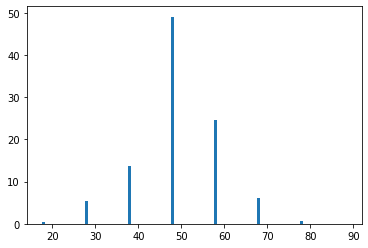

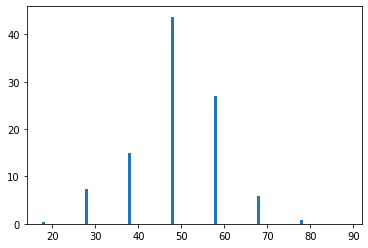

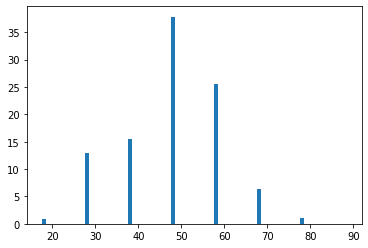

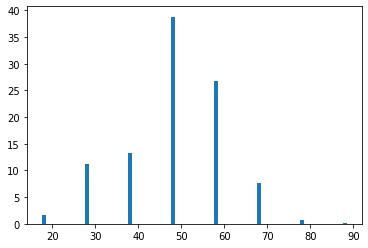

In [353]:
df_M = df_new[df_new["sex"] =="M"]
df_cm=pd.crosstab(df_M["examdate_year"], df_M["age_binned"],normalize='index') * 100
display(df_cm.round(2))
for _year in df_cm.index:
    
    list_left = [_interval.left for _interval in df_cm.keys().tolist()]
    plt.bar(list_left, df_cm.loc[_year, :].values)
    plt.show()

In [354]:
display(pd.crosstab(df_M['examdate_year'], df_M['Q0047 귀하는 담배를 피운적이 있습니까?']).round(2))
display(pd.crosstab(df_M['examdate_year'], df_M['Q0047 귀하는 담배를 피운적이 있습니까?'], 
           normalize = "index").round(2))
display(pd.crosstab(df_M['examdate_year'], df_M['Q0050 하루 평균 흡연량은 얼마입니까? (현재 끊으신분도 과거 하루 평균 흡연량 표시바랍니다)']))
display(pd.crosstab(df_M['examdate_year'], df_M['Q0050 하루 평균 흡연량은 얼마입니까? (현재 끊으신분도 과거 하루 평균 흡연량 표시바랍니다)'], 
           normalize = "index").round(2))

Q0047 귀하는 담배를 피운적이 있습니까?,,과거에 피웠으나 현재 끊었다,없음,현재 피운다
examdate_year,,,,
2015,16,1825,729,1358
2016,3,1514,560,1150
2017,1,963,415,704
2018,1,804,330,608


Q0047 귀하는 담배를 피운적이 있습니까?,,과거에 피웠으나 현재 끊었다,없음,현재 피운다
examdate_year,,,,
2015,0.0,0.46,0.19,0.35
2016,0.0,0.47,0.17,0.36
2017,0.0,0.46,0.20,0.34
2018,0.0,0.46,0.19,0.35


Q0050 하루 평균 흡연량은 얼마입니까? (현재 끊으신분도 과거 하루 평균 흡연량 표시바랍니다),,10개비 이하0.5갑,11-20개비 이상0.5-1갑,21-30개비 이상1-1.5갑,31개비 이상1.5갑
examdate_year,,,,,
2015,747,734,1438,660,349
2016,564,602,1174,585,302
2017,421,424,738,359,141
2018,335,356,650,287,115


Q0050 하루 평균 흡연량은 얼마입니까? (현재 끊으신분도 과거 하루 평균 흡연량 표시바랍니다),,10개비 이하0.5갑,11-20개비 이상0.5-1갑,21-30개비 이상1-1.5갑,31개비 이상1.5갑
examdate_year,,,,,
2015,0.19,0.19,0.37,0.17,0.09
2016,0.17,0.19,0.36,0.18,0.09
2017,0.20,0.20,0.35,0.17,0.07
2018,0.19,0.20,0.37,0.16,0.07


In [355]:
pd.pivot_table(df_M,
              index = "examdate_year", 
               
              columns = ['Q0047 귀하는 담배를 피운적이 있습니까?','Q0050 하루 평균 흡연량은 얼마입니까? (현재 끊으신분도 과거 하루 평균 흡연량 표시바랍니다)' ],
               values = "연구번호",
              aggfunc = "count").T

examdate_year                                                                 2015  \
Q0047 귀하는 담배를 피운적이 있습니까? Q0050 하루 평균 흡연량은 얼마입니까? (현재 끊으신분도 과거 하루 평균 흡연량 ...          
                                                                              16.0   
과거에 피웠으나 현재 끊었다                                                                NaN   
                         10개비 이하0.5갑                                         451.0   
                         11-20개비 이상0.5-1갑                                    795.0   
                         21-30개비 이상1-1.5갑                                    366.0   
                         31개비 이상1.5갑                                         213.0   
없음                                                                           729.0   
현재 피운다                                                                         2.0   
                         10개비 이하0.5갑                                         283.0   
                         11-20개비 이상0.5-1갑                                    643.0   
                         21-30개비 이상1-1.5갑                                    294.0   
                         31개비 이상1.5갑                                         136.0   

examdate_year                                                                 2016  \
Q0047 귀하는 담배를 피운적이 있습니까? Q0050 하루 평균 흡연량은 얼마입니까? (현재 끊으신분도 과거 하루 평균 흡연량 ...          
                                                                               3.0   
과거에 피웠으나 현재 끊었다                                                                1.0   
                         10개비 이하0.5갑                                         365.0   
                         11-20개비 이상0.5-1갑                                    642.0   
                         21-30개비 이상1-1.5갑                                    324.0   
                         31개비 이상1.5갑                                         182.0   
없음                                                                           560.0   
현재 피운다                                                                         NaN   
                         10개비 이하0.5갑                                         237.0   
                         11-20개비 이상0.5-1갑                                    532.0   
                         21-30개비 이상1-1.5갑                                    261.0   
                         31개비 이상1.5갑                                         120.0   

examdate_year                                                                 2017  \
Q0047 귀하는 담배를 피운적이 있습니까? Q0050 하루 평균 흡연량은 얼마입니까? (현재 끊으신분도 과거 하루 평균 흡연량 ...          
                                                                               1.0   
과거에 피웠으나 현재 끊었다                                                                4.0   
                         10개비 이하0.5갑                                         254.0   
                         11-20개비 이상0.5-1갑                                    409.0   
                         21-30개비 이상1-1.5갑                                    200.0   
                         31개비 이상1.5갑                                          96.0   
없음                                                                           415.0   
현재 피운다                                                                         1.0   
                         10개비 이하0.5갑                                         170.0   
                         11-20개비 이상0.5-1갑                                    329.0   
                         21-30개비 이상1-1.5갑                                    159.0   
                         31개비 이상1.5갑                                          45.0   

examdate_year                                                                 2018  
Q0047 귀하는 담배를 피운적이 있습니까? Q0050 하루 평균 흡연량은 얼마입니까? (현재 끊으신분도 과거 하루 평균 흡연량 ...         
                                                                               1.0  
과거에 피웠으나 현재 끊었다                                                                4.0  
                         10개비 이하0.5갑         

# GET SMOKING RELATED PARAMETERS FROM THE RESPONDS

In [289]:
df_new['Q0047 귀하는 담배를 피운적이 있습니까?'].value_counts()

없음                 6794
과거에 피웠으나 현재 끊었다    5304
현재 피운다             4024
                     26
Name: Q0047 귀하는 담배를 피운적이 있습니까?, dtype: int64

In [290]:
def ever_smoked(x):
    if type(x) ==str:
        if x == "없음":
            n_x = "Never"
        elif x == '과거에 피웠으나 현재 끊었다':
            n_x = "Ex"
        elif x == '현재 피운다':
            n_x = "Current"
        else:
            n_x = np.nan
    else: 
        n_x = np.nan
    return n_x

In [291]:
df_new["Smoked_ever"] = df_new['Q0047 귀하는 담배를 피운적이 있습니까?'].map(lambda x: ever_smoked(x))

In [294]:
df_new["Smoked_ever"].value_counts(dropna = False)

Never      6794
Ex         5304
Current    4024
NaN          26
Name: Smoked_ever, dtype: int64

In [305]:
import re
def strip_str(col):
    if type(col) == str:
        new_x = col[1:-1]
        new_x = re.sub('[()]', '', new_x)
        new_x = new_x.strip()
        if new_x=="":
            new_x = np.nan
        else:
            new_x = int(new_x)
    else:
        new_x =np.nan # np.nan으로 할 것인지 "N/A"로 할 것인지
    return new_x

In [317]:
def fyrs(df):
    if df["Smoked_ever"] == "Current":
        x = df["age"] 
    
    elif df["Smoked_ever"] == "Ex":
        if type(df["smoking_quit"]) == str:
            x = int(df["smoking_quit"])
        else:
            x = np.nan
    else:
        x = np.nan
    return x  

In [323]:
df_new["smoking_initiation"] = df_new['Q0048 처음 흡연을 시작한 연령은 몇 세입니까?'].map(lambda x: strip_str(x))
df_new["smoking_quit"] = df_new['Q0049 흡연을 중단한 연령은 몇 세입니까?'].map(lambda x: strip_str(x))
df_new["smoking_latest"]  = df_new.apply(fyrs, axis = 1)

<AxesSubplot:>

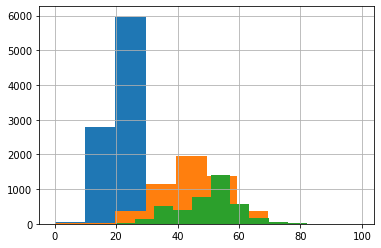

In [324]:
df_new["smoking_initiation"].hist()
df_new["smoking_quit"].hist()
df_new["smoking_latest"].hist()

count    4023.000000
mean       29.138205
std         9.466751
min        -2.000000
25%        23.000000
50%        30.000000
75%        35.000000
max        74.000000
dtype: float64

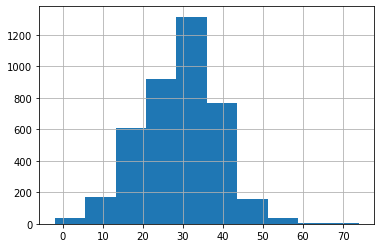

In [327]:
(df_new["smoking_latest"] - df_new["smoking_initiation"]).hist()
(df_new["smoking_latest"] - df_new["smoking_initiation"]).describe()

<AxesSubplot:>

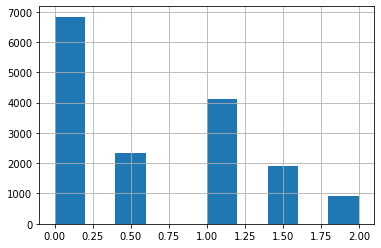

In [335]:
def replace_packperday(x):
    if x==' ':
        return 0
    elif x=='10개비 이하0.5갑':
        return 0.5
    elif x=='11-20개비 이상0.5-1갑':
        return 1
    elif x=='21-30개비 이상1-1.5갑':
        return 1.5
    elif x=='31개비 이상1.5갑':
        return 2


In [340]:
df_new["SMK_Yrs"] = df_new["smoking_latest"] - df_new["smoking_initiation"]

In [392]:
df_new[df_new["SMK_Yrs"] <0][["age","Smoked_ever", "smoking_initiation","smoking_quit", "smoking_latest", "pack_per_day", "PackYrs_by_cal"]]

,age,Smoked_ever,smoking_initiation,smoking_quit,smoking_latest,pack_per_day,PackYrs_by_cal
1174,59,Current,60.0,NaN,59.0,0.5,-0.5
3656,50,Current,52.0,NaN,50.0,1.5,-3.0
5040,59,Current,60.0,NaN,59.0,2.0,-2.0
8267,39,Current,40.0,NaN,39.0,1.0,-1.0
10918,39,Current,40.0,NaN,39.0,0.5,-0.5


<AxesSubplot:>

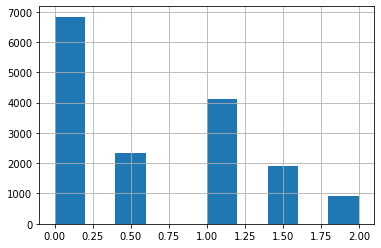

In [345]:
df_new["pack_per_day"] = df_new['Q0050 하루 평균 흡연량은 얼마입니까? (현재 끊으신분도 과거 하루 평균 흡연량 표시바랍니다)'].map(lambda x: replace_packperday(x))
df_new["pack_per_day"].hist()

In [347]:
df_new["PackYrs_by_cal"] = df_new["SMK_Yrs"] * df_new["pack_per_day"]

<AxesSubplot:>

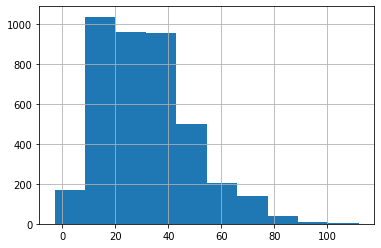

In [348]:
df_new["PackYrs_by_cal"].hist()

<AxesSubplot:>

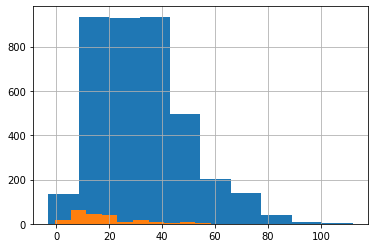

In [357]:
df_M["PackYrs_by_cal"].hist()
df_F["PackYrs_by_cal"].hist()


2015


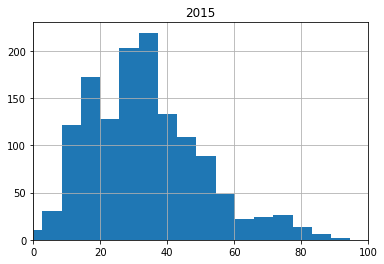

2016


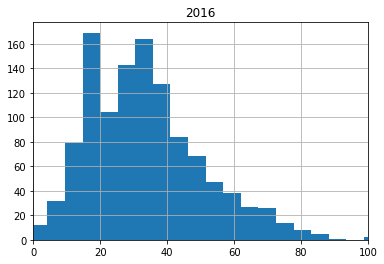

2017


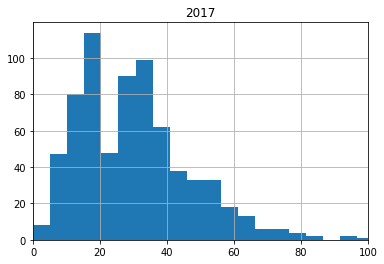

2018


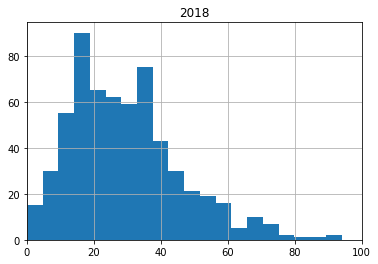

In [372]:
for _year in np.arange(2015, 2019):
    print(_year)
    df_target = df_M[(df_M["Smoked_ever"] !="Never")&(df_M["examdate_year"] ==_year)]
    df_target["PackYrs_by_cal"].hist(bins = 20)
    plt.xlim(0, 100)
    plt.title(_year)
    plt.show()

2015


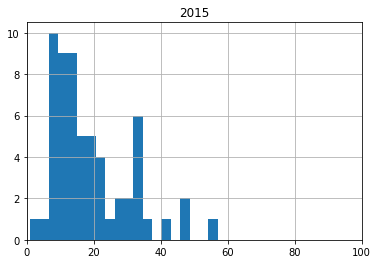

2016


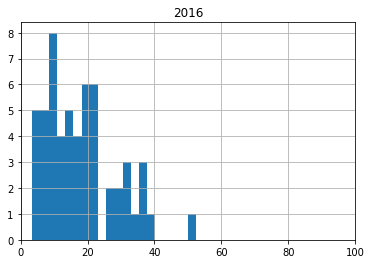

2017


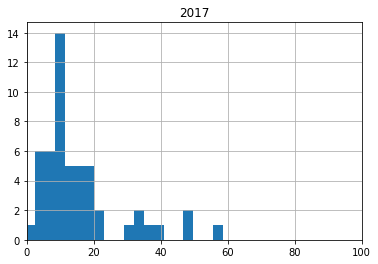

2018


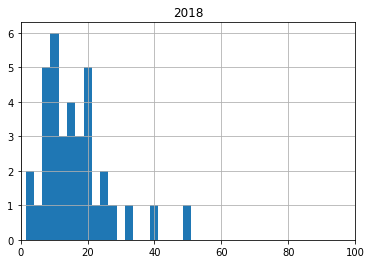

In [373]:
for _year in np.arange(2015, 2019):
    print(_year)
    df_target = df_F[(df_F["Smoked_ever"] !="Never")&(df_F["examdate_year"] ==_year)]
    df_target["PackYrs_by_cal"].hist(bins = 20)
    plt.xlim(0, 100)
    plt.title(_year)
    plt.show()

In [371]:
df_new[(df_new["Smoked_ever"] !="Never")&(df_new["examdate_year"] !=2018)].shape

(7873, 70)

array([[<AxesSubplot:title={'center':'PackYrs_by_cal'}>]], dtype=object)

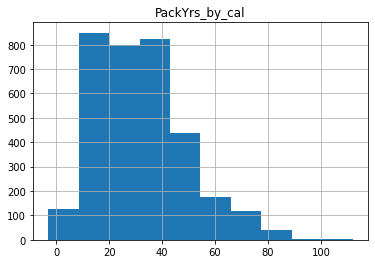

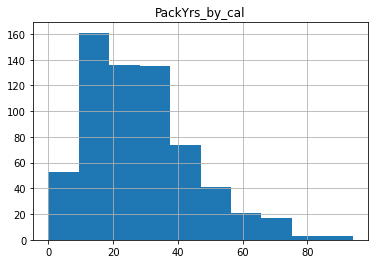

In [379]:
df_new[(df_new["Smoked_ever"] !="Never")&(df_new["examdate_year"] !=2018)][["PackYrs_by_cal"]].hist()
df_new[(df_new["Smoked_ever"] !="Never")&(df_new["examdate_year"] ==2018)][["PackYrs_by_cal"]].hist()

## DEVELOPMENT SET

In [399]:
display(df_new[(df_new["Smoked_ever"] !="Never")&(df_new["SMK_Yrs"] >=0)&(df_new["examdate_year"] !=2018)][["PackYrs_by_cal"]].describe())
print(df_new[(df_new["examdate_year"] !=2018)]["Smoked_ever"].value_counts(dropna = False))

display(pd.DataFrame(df_new[(df_new["examdate_year"] !=2018)]["Smoked_ever"].value_counts(dropna = False))/df_new[(df_new["examdate_year"] !=2018)].shape[0] * 100)

,PackYrs_by_cal
count,3374.000000
mean,31.963248
std,16.976008
min,0.000000
25%,18.000000
50%,31.000000
75%,41.000000
max,112.000000


Never      5555
Ex         4468
Current    3380
NaN          25
Name: Smoked_ever, dtype: int64


,Smoked_ever
Never,41.368782
Ex,33.273756
Current,25.171284
NaN,0.186178


## TEMPORALLY INDEPENDENT SET

In [402]:
display(df_new[(df_new["Smoked_ever"] !="Never")&(df_new["SMK_Yrs"] >=0)&(df_new["examdate_year"] ==2018)][["PackYrs_by_cal"]].describe())
print(df_new[(df_new["examdate_year"] ==2018)]["Smoked_ever"].value_counts())

display(pd.DataFrame(df_new[(df_new["examdate_year"] ==2018)]["Smoked_ever"].value_counts(dropna = False))/df_new[(df_new["examdate_year"] ==2018)].shape[0] * 100)

,PackYrs_by_cal
count,644.000000
mean,28.649068
std,16.313615
min,0.000000
25%,16.875000
50%,27.000000
75%,37.000000
max,94.000000


Never      1239
Ex          836
Current     644
Name: Smoked_ever, dtype: int64


,Smoked_ever
Never,45.551471
Ex,30.735294
Current,23.676471
NaN,0.036765


In [408]:
PackYrs_devel =df_new[(df_new["Smoked_ever"] !="Never")&(df_new["SMK_Yrs"] >=0)&(df_new["examdate_year"] !=2018)]["PackYrs_by_cal"]
PackYrs_2018 = df_new[(df_new["Smoked_ever"] !="Never")&(df_new["SMK_Yrs"] >=0)&(df_new["examdate_year"] ==2018)]["PackYrs_by_cal"]

In [410]:
mannwhitneyu(PackYrs_devel, PackYrs_2018).pvalue

1.2219735804437514e-06